## Проект определения лесов и зеленых насаждений  с помощью аэроснимков

Контекст

Автоматическая категоризация и сегментация лесного покрова имеет большое значение для устойчивого развития и городского планирования. Важность лесов нельзя недооценивать, поскольку они поддерживают поток основных экосистемных услуг, таких как волокна, энергия, отдых, биоразнообразие, хранение углерода и поток и вода. Леса также являются важными областями, которые необходимо определить, прежде чем начинать какую-либо промышленную деятельность, которая требует проведения полевых работ. Спутниковые или удаленные изображения могут быть использованы для идентификации и сегментирования регионов лесного покрова на изображении и получения четкого представления о том, сколько земли покрыто лесом. Эта проблема определяется как задача бинарной сегментации для обнаружения лесных районов.
Контент

Этот набор данных содержит 5108 аэрофотоснимков размером 256x256
Файл meta_data.csv хранит информацию об аэрофотоснимках и их соответствующих изображениях в двоичных масках
Благодарности

Этот набор данных был получен из классификационного трека Land Cover в DeepGlobe Challenge. Для получения более подробной информации о наборе данных ссылайтесь на соответствующую публикацию - DeepGlobe 2018: A Challenge to Murse the Earth through Satellite Images. Изображения в наборе данных были исправлены в изображениях размера 256x256, чтобы создать большее количество образцов изображений.

Любая работа, основанная на наборе данных, должна содержать:
@InProceedings{DeepGlobe18,
author = {Demir, Ilke and Koperski, Krzysztof and Lindenbaum, David and Pang, Guan and Huang, Jing and Basu, Saikat and Hughes, Forest and Tuia, Devis and Raskar, Ramesh},
title = {DeepGlobe 2018: A Challenge to Parse the Earth Through Satellite Images},
booktitle = {The IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops},
month = {June},
year = {2018}
}

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Работа с файлами
import os
import shutil
import kagglehub
import zipfile
from tqdm import tqdm

import cv2
import random

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torchutils as tu
from torchmetrics.functional.detection.iou import intersection_over_union

import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, confusion_matrix, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# from PIL import Image, ImageOps
# from src.mnist_localization import get_dataloaders

import mlflow      
import mlflow.pytorch  

import mplcyberpunk
plt.style.use('cyberpunk')

/home/andre/Elbrus-DataScience/lessons/project_elb/cv_yolo26/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [135]:
def plot_logs(hist):
    fig = plt.figure(figsize=[14,12])

    ax1 = plt.subplot2grid((4, 2), (0,0))
    ax1.plot(hist['train_loss'], label='train')
    ax1.plot(hist['valid_loss'], linestyle='--', label='valid')
    ax1.set_xlabel('Epoch', fontsize=9)
    ax1.legend()
    ax1.set_title(f'DiceLoss')

    ax2 = plt.subplot2grid((4, 2), (0,1))
    ax2.plot(hist['train_iou'])
    ax2.plot(hist['valid_iou'], linestyle='--')
    ax2.set_xlabel('Epoch', fontsize=9)
    ax2.set_title(f'IoU')

    ax3 = plt.subplot2grid((4, 2), (1,0), colspan=2)
    ax3.plot(hist['train_f1'], label='train')
    ax3.plot(hist['valid_f1'], linestyle='--')
    ax3.set_xlabel('Epoch', fontsize=9)
    ax3.set_title(f'F1')

    ax4 = plt.subplot2grid((4, 2), (2,0), colspan=2)
    ax4.plot(hist['valid_pr_auc'], label='pr_auc')
    ax4.plot(hist['valid_roc_auc'], linestyle='--', label='roc_auc')
    ax4.legend()
    ax4.set_xlabel('Epoch', fontsize=9)
    ax4.set_title(f'PR-AUC')

    ax5 = plt.subplot2grid((4, 2), (3,0), colspan=2)
    ax5.plot(hist['valid_precision'], label='Precision')
    ax5.plot(hist['valid_recall'], linestyle='--', label='Recall')
    ax5.set_xlabel('Epoch', fontsize=9)
    ax5.legend()
    ax5.set_title(f'Precision_Recall')

    plt.legend()

    plt.tight_layout()
    plt.show()

In [2]:
# [MLflow] Флажок, чтобы включать/выключать логирование
use_mlflow = True

# Здесь можно выбрать или задать название эксперимента
# (если такового нет, MLflow создаст новый)
mlflow_experiment_name = "Forest_Unet_project"

In [3]:
BATCH_SIZE = 16

config = {
    'batch_size': BATCH_SIZE,
    'learning_rate': 0.001,
    'epochs': 10,
    'use_mlflow': use_mlflow,
    'device':  'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': 'data/',
    'experiment_name': mlflow_experiment_name, 
    'log_dir': 'runs/experiment1'
}

# ниже строка не обязательна, но часто device хранят еще и в отдельной переменной, так как часто обращаются к ней
DEVICE = config['device'] #'cuda' if torch.cuda.is_available() else 'cpu'

Загружаем датасет `Forest Aerial Images for Segmentation` с kaggle

In [4]:
# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /home/andre/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2


In [5]:
# сохраняем в папку data
source = '/home/andre/.cache/kagglehub/datasets/quadeer15sh/augmented-forest-segmentation/versions/2/Forest Segmented'
destination = '../data/'

# Копирует всю папку целиком
shutil.copytree(source, destination, dirs_exist_ok=True)

print("Готово!")

Готово!


In [6]:
# Сохраняем пути для следующего шага
BASE_DIR = os.path.join('..', 'data', 'Forest Segmented')
IMAGE_DIR = os.path.join(BASE_DIR, "images")
MASK_DIR = os.path.join(BASE_DIR, "masks")
CSV_PATH = os.path.join(BASE_DIR, 'meta_data.csv')

Проверим датасет на соответствие данных

In [7]:
path2data = r"../data/Forest Segmented"
df_meta = pd.read_csv(os.path.join(path2data, "meta_data.csv"))
df_meta.head()

image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg

In [8]:
df_meta.shape

(5108, 2)

In [9]:
images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
masks = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.jpg')])

print(f"Картинок: {len(images)} | Масок: {len(masks)}")

# Проверяем соответствие имен (убираем '_sat_' и '_mask_' для сравнения)
mismatches = [i for i, m in zip(images, masks) 
              if i.replace('_sat_', '') != m.replace('_mask_', '')]

# Итоговый вердикт
if not mismatches and len(images) == len(masks):
    print("Все файлы соответствуют друг другу")
else:
    print(f"Ошибок в парах: {len(mismatches)}")
    if mismatches: print(f"Первая ошибка: {mismatches[0]}")

Картинок: 5108 | Масок: 5108
Все файлы соответствуют друг другу


In [10]:
# 1. Берем по одному файлу из папок
test_img_name = os.listdir(IMAGE_DIR)[10]
test_mask_name = os.listdir(MASK_DIR)[10]

# 2. Склеиваем путь к папке и имя файла
img = cv2.imread(os.path.join(IMAGE_DIR, test_img_name))
mask = cv2.imread(os.path.join(MASK_DIR, test_mask_name), 0)

# 3. Проверяем
print(f"Маска найдена, ее тип: {mask.dtype}")
print(f"Цифры в маске (уникальные): {np.unique(mask)}")
print(f"Размер фото: {img.shape}, размер маски: {mask.shape}")

Маска найдена, ее тип: uint8
Цифры в маске (уникальные): [  0   1   2   3   4   5   6   7 248 249 250 251 252 253 254 255]
Размер фото: (256, 256, 3), размер маски: (256, 256)


В ходе первичного анализа выборки (n=250, ~5% датасета) визуально были выявлены следующие отклонения исходной разметки: 
- нечеткие границы лесного массива
- ошибочная разметка
- отсутствие разметки там, где есть лес

2-5 отлонений в каждом из 10 случайных наборов(папка images)

Это может привести к сижению точности сегментации

Для минимизации влияния этих отклонений при обучении применить аугментацию

Маска файла содержит 16 уникальных значений. Намнужно только 2 так как мы определяем наличие леса, деревьев на картинке и их выделение.
Учтем это в обработке чтобы осталось 2 уникальных цифры. Лес отмечается белым (255)

### Разделяем датасет на train, test и valid

In [11]:
# 1. Отделяем тренировочную выборку (80%) от остатка (20%)
train_df, temp_df = train_test_split(df_meta, test_size=0.2, random_state=42)

# 2. Остаток (20%) делим пополам на валидацию (0.7) и тест (0.3)
val_df, test_df = train_test_split(temp_df, test_size=0.3, random_state=42)

print(f"Тренировочных: {len(train_df)}, Валидационных: {len(val_df)}, Тестовых: {len(test_df)}")

Тренировочных: 4086, Валидационных: 715, Тестовых: 307


## Создаем `Dataset` и `DataLoader`

In [12]:
class AeroForestDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, transform=None):
        self.df = df.reset_index(drop=True) # Важно сбросить индексы после split
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):

        img_name = self.df.iloc[index]['image']
        mask_name = self.df.iloc[index]['mask']

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, 0)
        mask = (mask > 128).astype(np.float32)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1) / 255.0).float()
            mask = torch.from_numpy(mask).float()

        if mask.ndim == 2:
            mask = mask.unsqueeze(0)

        return image, mask



In [13]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Набор правил для тренировочных данных
train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),      # Отразить по горизонтали (вероятность 50%)
    A.VerticalFlip(p=0.5),        # Отразить по вертикали
    A.RandomRotate90(p=0.5),      # Повернуть на 90 градусов
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5), # Легкие искажения
    A.Normalize(
        mean=mean, 
        std=std
    ),
    ToTensorV2() 
])

train_transform_mod = A.Compose([
    A.Resize(256, 256),
    
    # ГЕОМЕТРИЯ
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    
    # 1. ГРУБЫЕ ИСКАЖЕНИЯ (для плохой разметки)
    # Помогает модели не привыкать к конкретным контурам
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    
    # 2. РАБОТА С ЦВЕТОМ
    # Чтобы модель не зависела от того, насколько яркое фото
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    
    # 3. ШУМ И РАЗМЫТИЕ
    # Маскирует ошибки в разметке пикселей
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 5), p=1.0),
        A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
    ], p=0.3),

    # 4. СЛУЧАЙНОЕ УДАЛЕНИЕ (CoarseDropout)
    # Заставляет модель "додумывать" куски леса, если они перекрыты
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),

    A.Normalize(mean=mean, std=std),
    ToTensorV2() 
])

In [14]:
valid_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(
        mean=mean, 
        std=std
    ),
    ToTensorV2() 
])

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(
        mean=mean, 
        std=std
    ),
    ToTensorV2() 
])

In [15]:
train_dataset = AeroForestDataset(
    train_df, 
    IMAGE_DIR, 
    MASK_DIR, 
    transform=train_transform)

train_dataset_modif = AeroForestDataset(
    train_df, 
    IMAGE_DIR, 
    MASK_DIR, 
    transform=train_transform_mod)


valid_dataset = AeroForestDataset(
    val_df, 
    IMAGE_DIR, 
    MASK_DIR, transform=valid_transform)
test_dataset = AeroForestDataset(test_df, IMAGE_DIR, MASK_DIR, transform=test_transform)

# Загрузчики остаются такими же
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
train_loader_modif = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

In [16]:
print(train_df.columns)

Index(['image', 'mask'], dtype='object')


In [17]:

images, masks = next(iter(train_loader))
print(f"Изображения: {images.shape}") # Ожидаем [batch_size, 3, 256, 256]
print(f"Маски: {masks.shape}")       # Ожидаем [batch_size, 1, 256, 


Изображения: torch.Size([16, 3, 256, 256])
Маски: torch.Size([16, 1, 256, 256])


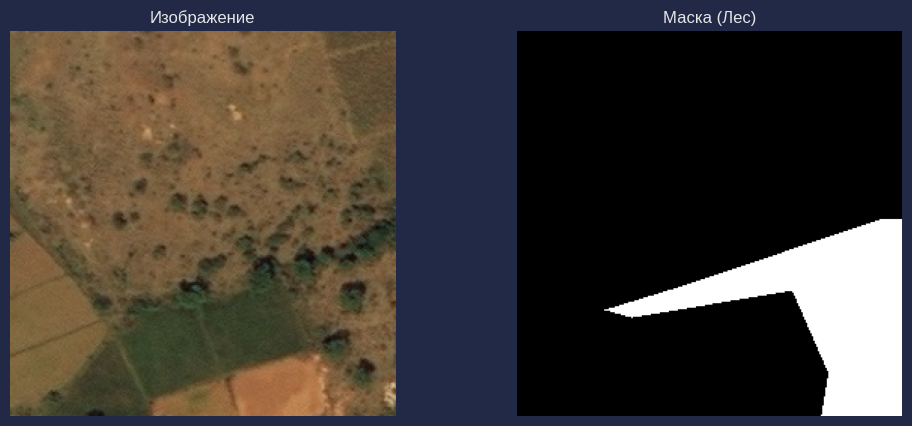

In [18]:
img = images[6].cpu().permute(1, 2, 0).numpy()
mask = masks[6].cpu().squeeze().numpy() # squeeze уберет лишний канал [1, 256, 256] -> [256, 256]

# 2. ДЕНОРМАЛИЗАЦИЯ (если в трансформах был A.Normalize)
# Если вы использовали стандартные средние ImageNet:
# mean = np.array([0.485, 0.456, 0.406])
# std = np.array([0.229, 0.224, 0.225])
img = std * img + mean # так интересно инвертирует изображение
img = np.clip(img, 0, 1) # ограничиваем значения от 0 до 1

# 3. Сама отрисовка
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Изображение")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Маска (Лес)")
plt.axis('off')

plt.show()

Некоторые маски вызываю вопросы

## Создаем модель Unet

In [19]:
# Создаем модель
model = smp.Unet(
    encoder_name="resnet34",        # Энкодер (можно менять на resnet50, efficientnet-b0 и т.д.)
    encoder_weights="imagenet",     # Используем веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (лес / не лес)
    activation=None                 # Оставляем логиты (удобнее для функции потерь)
)

# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [20]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary')

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [21]:
# Берем один батч из тех, что вы уже вывели на экран
images = images.to(DEVICE)
with torch.no_grad():
    output = model(images)

print(f"Форма предсказания: {output.shape}") # Ожидаем [16, 1, 256, 256]

Форма предсказания: torch.Size([16, 1, 256, 256])


In [22]:
def run_train_pipeline(model, optimizer, criterion, train_loader, valid_loader, config, device, run_name="Experiment"):
    """
    Обертка над процессом обучения с поддержкой MLflow
    """
    use_mlflow = config.get('use_mlflow', False)
    
    if use_mlflow:
        mlflow.set_experiment(config.get('experiment_name', "Default_Experiment"))
        
        with mlflow.start_run(run_name=run_name):
            # 1. Логируем параметры
            mlflow.log_params({
                'batch_size': config['batch_size'],
                'learning_rate': config['learning_rate'],
                'epochs': config['epochs'],
                'device': str(device),
                'encoder': config.get('encoder', 'unknown')
            })

            # 2. Запуск обучения
            history = fit(
                model=model, 
                n_epochs=config['epochs'], 
                optimizer=optimizer, 
                train_loader=train_loader, 
                valid_loader=valid_loader,
                criterion=criterion,
                device=device,
                config=config
            )

            # 3. Логируем модель (с учетом ворнинга используем 'name')
            mlflow.pytorch.log_model(model, name='model_forest')
            
            return history
    else:
        # Обычный запуск без MLflow
        return fit(
            model, config['epochs'], optimizer, 
            train_loader, valid_loader, criterion, device, config
        )


In [23]:
def fit(model, n_epochs, optimizer, train_loader, valid_loader, criterion, device, config):
    """
    Полная версия функции обучения.
    Включает: IoU, F1, ROC AUC, PR AUC, Scheduler и MLflow.
    """
    
    # Инициализация планировщика (снижает LR, если valid_loss не падает 2 эпохи)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2
    )

    history = {
        'train_loss': [], 'valid_loss': [],
        'train_iou': [], 'valid_iou': [],
        'train_f1': [], 'valid_f1': [],
        'valid_precision': [], 'valid_recall': [],
        'valid_roc_auc': [], 'valid_pr_auc': []
    }

    for epoch in range(n_epochs):
        # --- ФАЗА ОБУЧЕНИЯ ---
        model.train()
        train_loss, train_iou, train_f1 = [], [], []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs} [Train]")
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                tp, fp, fn, tn = smp.metrics.get_stats(
                    output=outputs, target=masks.long(), mode='binary', threshold=0.5
                )
                iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
                f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")

            train_loss.append(loss.item())
            train_iou.append(iou.item())
            train_f1.append(f1.item())
            
            pbar.set_postfix(loss=f"{loss.item():.4f}", iou=f"{iou.item():.4f}", f1=f"{f1.item():.4f}")

        # --- ФАЗА ВАЛИДАЦИИ ---
        model.eval()
        val_loss, val_iou, val_f1, val_precision, val_recall = [], [], [], [], []
        all_probs, all_targets = [], [] 
        
        with torch.no_grad():
            for images, masks in valid_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                
                
                # Сбор данных для AUC (вероятности через sigmoid)
                probs = torch.sigmoid(outputs).cpu().numpy().flatten()
                targets = masks.cpu().numpy().flatten()
                all_probs.append(probs)
                all_targets.append(targets)

                tp, fp, fn, tn = smp.metrics.get_stats(
                    output=outputs, target=masks.long(), mode='binary', threshold=0.5
                )

                precision = smp.metrics.precision(tp, fp, fn, tn, reduction="micro")
                recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro")    

                val_loss.append(loss.item())
                val_iou.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item())
                val_f1.append(smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item())

                val_precision.append(precision.item())
                val_recall.append(recall.item())                

        # Средние показатели
        e_train_loss = np.mean(train_loss)
        e_train_iou = np.mean(train_iou)
        e_train_f1 = np.mean(train_f1)
        
        e_val_loss = np.mean(val_loss)
        e_val_iou = np.mean(val_iou)
        e_val_f1 = np.mean(val_f1)

        e_val_precision = np.mean(val_precision)
        e_val_recall = np.mean(val_recall)        

        # Расчет AUC (на всем валидационном сете сразу)
        y_true = np.concatenate(all_targets)
        y_score = np.concatenate(all_probs)
        e_val_roc_auc = roc_auc_score(y_true, y_score)
        e_val_pr_auc = average_precision_score(y_true, y_score)

        # Шаг планировщика
        scheduler.step(e_val_loss)
        current_lr = optimizer.param_groups[0]['lr']

        # Запись в историю
        history['train_loss'].append(e_train_loss)
        history['train_iou'].append(e_train_iou)
        history['train_f1'].append(e_train_f1)
        history['valid_loss'].append(e_val_loss)
        history['valid_iou'].append(e_val_iou)
        history['valid_f1'].append(e_val_f1)
        history['valid_precision'].append(e_val_precision) # Добавили
        history['valid_recall'].append(e_val_recall)       # Добавили
        history['valid_roc_auc'].append(e_val_roc_auc)
        history['valid_pr_auc'].append(e_val_pr_auc)

        # --- MLFLOW ЛОГИРОВАНИЕ ---
        if mlflow.active_run():
            mlflow.log_metrics({
                'train_loss': e_train_loss,
                'train_iou': e_train_iou,
                'train_f1': e_train_f1,
                'valid_loss': e_val_loss,
                'valid_iou': e_val_iou,
                'valid_f1': e_val_f1,
                'valid_precision': e_val_precision,  # Новое
                'valid_recall': e_val_recall,        # Новое
                'valid_roc_auc': e_val_roc_auc,
                'valid_pr_auc': e_val_pr_auc,
                'learning_rate': current_lr
            }, step=epoch)
            print(f"Записан расширенный лог в mlflow Epoch {epoch+1}")

        # Печать результатов
        print(f"\n[Summary Epoch {epoch+1}]")
        print(f"Train -> Loss: {e_train_loss:.4f} | IoU: {e_train_iou:.4f} | F1: {e_train_f1:.4f}")
        print(f"Valid -> Loss: {e_val_loss:.4f} | IoU: {e_val_iou:.4f} | F1: {e_val_f1:.4f}")
        print(f"Metrics -> Precision: {e_val_precision:.4f} | Recall: {e_val_recall:.4f} | ROC AUC: {e_val_roc_auc:.4f} | PR AUC: {e_val_pr_auc:.4f}")
        print(f"Learning Rate: {current_lr}\n")

        del all_probs, all_targets, y_true, y_score

        if str(device) == 'cuda':
            torch.cuda.empty_cache()

    return history


In [24]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary')

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [25]:
config

{'batch_size': 16,
 'learning_rate': 0.001,
 'epochs': 10,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [26]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_Resnet34_Forest_v1'
)

2026/02/19 23:17:29 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/19 23:17:29 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/19 23:17:29 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/19 23:17:29 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/19 23:17:29 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/19 23:17:29 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/19 23:17:30 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/19 23:17:30 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/19 23:17:30 INFO mlflow.tracking.fluent: Experiment with name 'Forest_Unet_project' does not exist. Creating a new experiment.
Epoch 1/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.06it/s, f1=0.9040, iou=0.8248, loss=0.1314]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2380 | IoU: 0.6672 | F1: 0.7925
Valid -> Loss: 0.1835 | IoU: 0.7330 | F1: 0.8442
Metrics -> Precision: 0.8526 | Recall: 0.8395 | ROC AUC: 0.8761 | PR AUC: 0.8898
Learning Rate: 0.0001



Epoch 2/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.14it/s, f1=0.9496, iou=0.9041, loss=0.0747]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1681 | IoU: 0.7458 | F1: 0.8529
Valid -> Loss: 0.1539 | IoU: 0.7577 | F1: 0.8607
Metrics -> Precision: 0.8545 | Recall: 0.8696 | ROC AUC: 0.8909 | PR AUC: 0.9087
Learning Rate: 0.0001



Epoch 3/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.13it/s, f1=0.6048, iou=0.4335, loss=0.3980]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1530 | IoU: 0.7557 | F1: 0.8589
Valid -> Loss: 0.1414 | IoU: 0.7669 | F1: 0.8667
Metrics -> Precision: 0.8288 | Recall: 0.9107 | ROC AUC: 0.8943 | PR AUC: 0.9122
Learning Rate: 0.0001



Epoch 4/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.7396, iou=0.5868, loss=0.2652]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1447 | IoU: 0.7607 | F1: 0.8624
Valid -> Loss: 0.1424 | IoU: 0.7624 | F1: 0.8638
Metrics -> Precision: 0.7988 | Recall: 0.9430 | ROC AUC: 0.8863 | PR AUC: 0.8989
Learning Rate: 0.0001



Epoch 5/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.14it/s, f1=0.8388, iou=0.7224, loss=0.1645]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1417 | IoU: 0.7617 | F1: 0.8630
Valid -> Loss: 0.1402 | IoU: 0.7628 | F1: 0.8640
Metrics -> Precision: 0.8531 | Recall: 0.8779 | ROC AUC: 0.8936 | PR AUC: 0.9069
Learning Rate: 0.0001



Epoch 6/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.13it/s, f1=0.9578, iou=0.9191, loss=0.0460]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1357 | IoU: 0.7690 | F1: 0.8677
Valid -> Loss: 0.1369 | IoU: 0.7666 | F1: 0.8663
Metrics -> Precision: 0.8187 | Recall: 0.9229 | ROC AUC: 0.8616 | PR AUC: 0.8687
Learning Rate: 0.0001



Epoch 7/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.13it/s, f1=0.9159, iou=0.8449, loss=0.0856]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1379 | IoU: 0.7641 | F1: 0.8646
Valid -> Loss: 0.1320 | IoU: 0.7721 | F1: 0.8697
Metrics -> Precision: 0.8305 | Recall: 0.9156 | ROC AUC: 0.8944 | PR AUC: 0.9073
Learning Rate: 0.0001



Epoch 8/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.9147, iou=0.8428, loss=0.0873]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1336 | IoU: 0.7698 | F1: 0.8683
Valid -> Loss: 0.1336 | IoU: 0.7682 | F1: 0.8674
Metrics -> Precision: 0.8192 | Recall: 0.9243 | ROC AUC: 0.8866 | PR AUC: 0.8970
Learning Rate: 0.0001



Epoch 9/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.6425, iou=0.4733, loss=0.3581]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1336 | IoU: 0.7692 | F1: 0.8679
Valid -> Loss: 0.1299 | IoU: 0.7737 | F1: 0.8711
Metrics -> Precision: 0.8269 | Recall: 0.9228 | ROC AUC: 0.8925 | PR AUC: 0.9021
Learning Rate: 0.0001



Epoch 10/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.13it/s, f1=0.8381, iou=0.7213, loss=0.1628]
2026/02/19 23:25:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1301 | IoU: 0.7741 | F1: 0.8710
Valid -> Loss: 0.1274 | IoU: 0.7776 | F1: 0.8734
Metrics -> Precision: 0.8351 | Recall: 0.9179 | ROC AUC: 0.8942 | PR AUC: 0.9054
Learning Rate: 0.0001



In [27]:
history_all = {}
history_all['Unet_ResNet_base'] = history

In [24]:

def plot_segmentation_confusion_matrix(model, dataloader, device, threshold=0.5):
    model.eval()
    
    # Инициализируем пустую матрицу 2x2 (для фона и леса)
    overall_cm = np.zeros((2, 2))
    
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            
            # 1. Бинаризуем предсказания и переводим в одномерный массив
            preds = (outputs.sigmoid() > threshold).cpu().view(-1).numpy().astype(int)
            targets = masks.view(-1).numpy().astype(int)
            
            # 2. Считаем матрицу для ТЕКУЩЕГО батча
            # labels=[0, 1] гарантирует, что матрица всегда будет 2x2
            batch_cm = confusion_matrix(targets, preds, labels=[0, 1])
            
            # 3. Плюсуем к общей матрице
            overall_cm += batch_cm

    # Нормализация для процентов (по строкам)
    cm_norm = overall_cm.astype('float') / overall_cm.sum(axis=1)[:, np.newaxis]

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt=".2%", cmap='Blues', 
                xticklabels=['Background', 'Forest'], 
                yticklabels=['Background', 'Forest'])
    
    plt.title(f'Normalized Confusion Matrix (Total: {len(dataloader.dataset)} images)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



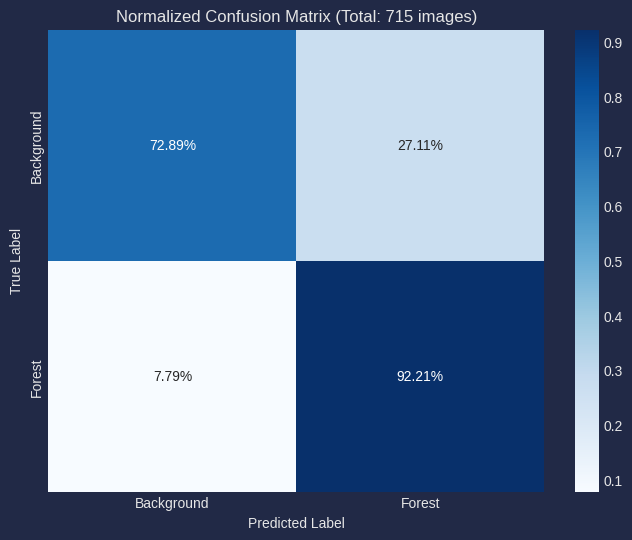

In [29]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)

In [134]:
def plot_logs(hist):
    fig = plt.figure(figsize=[14,12])

    ax1 = plt.subplot2grid((4, 2), (0,0))
    ax1.plot(hist['train_loss'], label='train')
    ax1.plot(hist['valid_loss'], linestyle='--', label='valid')
    ax1.set_xlabel('Epoch', fontsize=9)
    ax1.legend()
    ax1.set_title(f'DiceLoss')

    ax2 = plt.subplot2grid((4, 2), (0,1))
    ax2.plot(hist['train_iou'])
    ax2.plot(hist['valid_iou'], linestyle='--')
    ax2.set_xlabel('Epoch', fontsize=9)
    ax2.set_title(f'IoU')

    ax3 = plt.subplot2grid((4, 2), (1,0), colspan=2)
    ax3.plot(hist['train_f1'], label='train')
    ax3.plot(hist['valid_f1'], linestyle='--')
    ax3.set_xlabel('Epoch', fontsize=9)
    ax3.set_title(f'F1')

    ax4 = plt.subplot2grid((4, 2), (2,0), colspan=2)
    ax4.plot(hist['valid_pr_auc'], label='pr_auc')
    ax4.plot(hist['valid_roc_auc'], linestyle='--', label='roc_auc')
    ax4.legend()
    ax4.set_xlabel('Epoch', fontsize=9)
    ax4.set_title(f'PR-AUC')

    ax5 = plt.subplot2grid((4, 2), (3,0), colspan=2)
    ax5.plot(hist['valid_precision'], label='Precision')
    ax5.plot(hist['valid_recall'], linestyle='--', label='Recall')
    ax5.set_xlabel('Epoch', fontsize=9)
    ax5.legend()
    ax5.set_title(f'Precision_Recall')

    plt.legend()

    plt.tight_layout()
    plt.show()

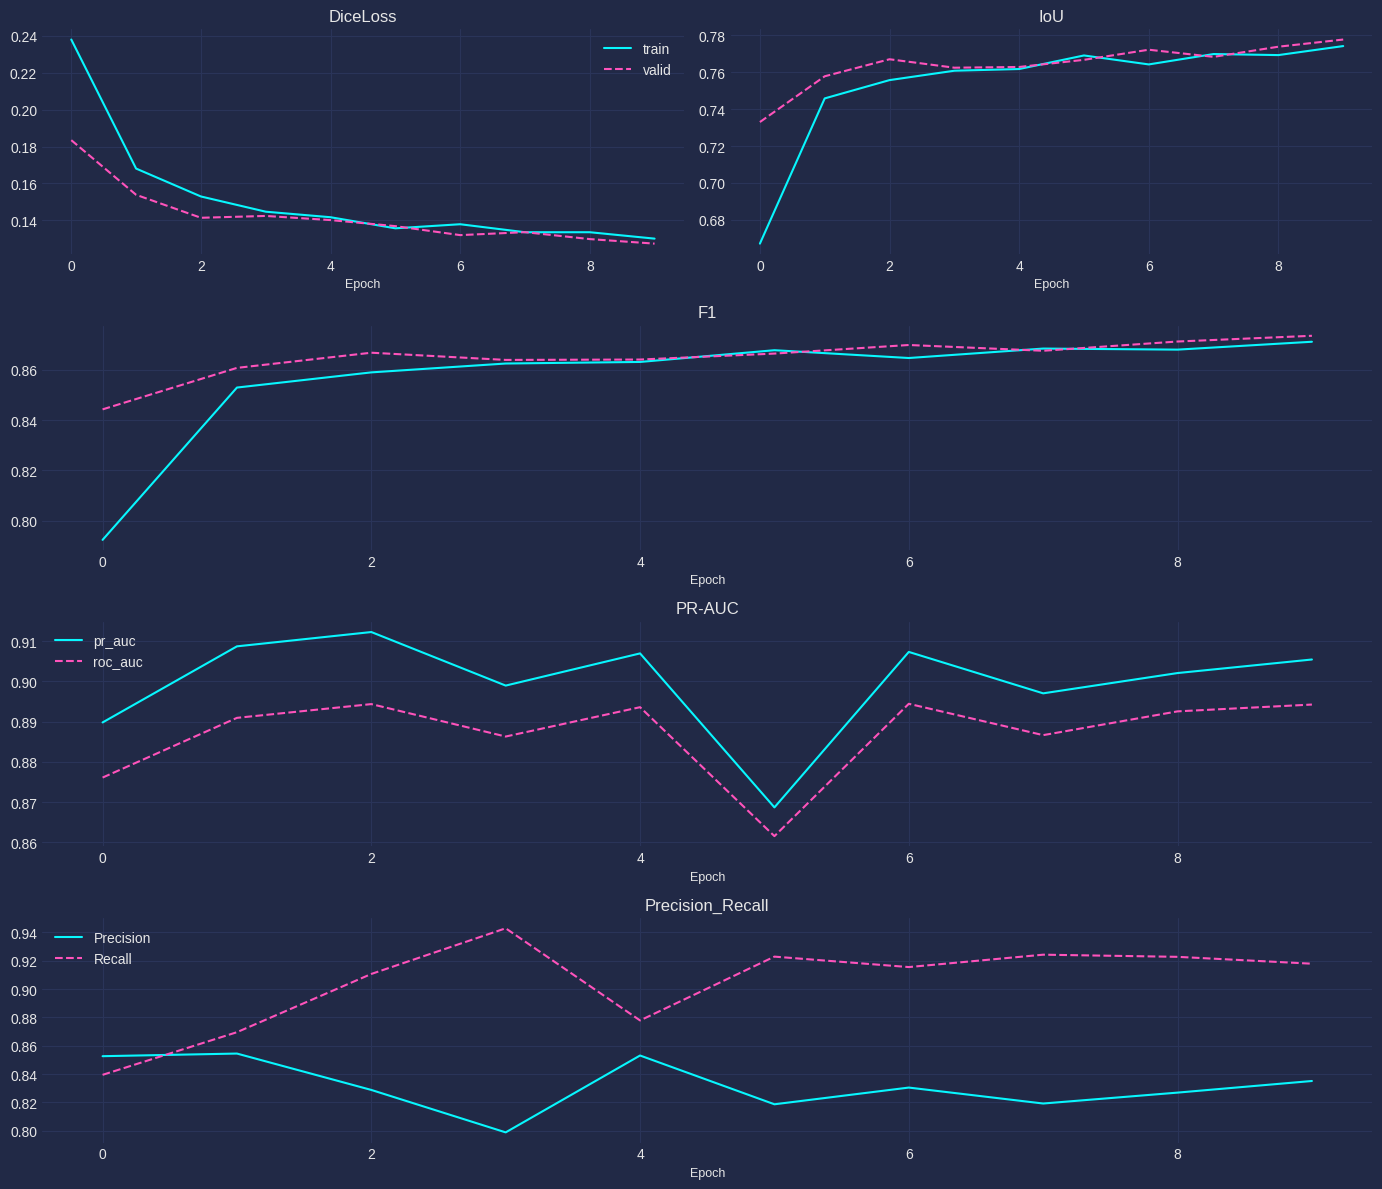

In [31]:
plot_logs(history_all['Unet_ResNet_base'])

На графиках видно, что обучение в конце идет волнами

Уменьшим learning rate

In [32]:
# Создаем модель
model = smp.Unet(
    encoder_name="resnet34",        # Энкодер (можно менять на resnet50, efficientnet-b0 и т.д.)
    encoder_weights="imagenet",     # Используем веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (лес / не лес)
    activation=None                 # Оставляем логиты (удобнее для функции потерь)
)

# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [33]:
config['learning_rate'] = 0.0001

In [34]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary')

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

In [35]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_Resnet34_Forest_v2_mod'
)

Epoch 1/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.9089, iou=0.8331, loss=0.1294]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2423 | IoU: 0.6654 | F1: 0.7876
Valid -> Loss: 0.1876 | IoU: 0.7347 | F1: 0.8453
Metrics -> Precision: 0.8416 | Recall: 0.8521 | ROC AUC: 0.8762 | PR AUC: 0.8969
Learning Rate: 0.0001



Epoch 2/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8881, iou=0.7987, loss=0.1343]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1707 | IoU: 0.7458 | F1: 0.8530
Valid -> Loss: 0.1538 | IoU: 0.7604 | F1: 0.8621
Metrics -> Precision: 0.8196 | Recall: 0.9114 | ROC AUC: 0.8826 | PR AUC: 0.8965
Learning Rate: 0.0001



Epoch 3/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.7201, iou=0.5627, loss=0.2828]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1547 | IoU: 0.7542 | F1: 0.8582
Valid -> Loss: 0.1479 | IoU: 0.7581 | F1: 0.8607
Metrics -> Precision: 0.8441 | Recall: 0.8808 | ROC AUC: 0.8853 | PR AUC: 0.8983
Learning Rate: 0.0001



Epoch 4/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.9260, iou=0.8623, loss=0.0792]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1452 | IoU: 0.7605 | F1: 0.8625
Valid -> Loss: 0.1409 | IoU: 0.7654 | F1: 0.8657
Metrics -> Precision: 0.8240 | Recall: 0.9149 | ROC AUC: 0.8911 | PR AUC: 0.9010
Learning Rate: 0.0001



Epoch 5/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8968, iou=0.8129, loss=0.1094]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1419 | IoU: 0.7628 | F1: 0.8637
Valid -> Loss: 0.1385 | IoU: 0.7669 | F1: 0.8665
Metrics -> Precision: 0.8084 | Recall: 0.9366 | ROC AUC: 0.8877 | PR AUC: 0.8966
Learning Rate: 0.0001



Epoch 6/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.8898, iou=0.8015, loss=0.1135]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1350 | IoU: 0.7703 | F1: 0.8687
Valid -> Loss: 0.1395 | IoU: 0.7626 | F1: 0.8636
Metrics -> Precision: 0.7964 | Recall: 0.9464 | ROC AUC: 0.8812 | PR AUC: 0.8881
Learning Rate: 0.0001



Epoch 7/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.8692, iou=0.7686, loss=0.1343]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1363 | IoU: 0.7673 | F1: 0.8666
Valid -> Loss: 0.1338 | IoU: 0.7700 | F1: 0.8686
Metrics -> Precision: 0.8515 | Recall: 0.8894 | ROC AUC: 0.8945 | PR AUC: 0.9055
Learning Rate: 0.0001



Epoch 8/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.8312, iou=0.7112, loss=0.1701]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1328 | IoU: 0.7710 | F1: 0.8693
Valid -> Loss: 0.1282 | IoU: 0.7770 | F1: 0.8733
Metrics -> Precision: 0.8264 | Recall: 0.9282 | ROC AUC: 0.8949 | PR AUC: 0.9043
Learning Rate: 0.0001



Epoch 9/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8517, iou=0.7417, loss=0.1502]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1328 | IoU: 0.7710 | F1: 0.8690
Valid -> Loss: 0.1316 | IoU: 0.7721 | F1: 0.8699
Metrics -> Precision: 0.8226 | Recall: 0.9254 | ROC AUC: 0.8897 | PR AUC: 0.8971
Learning Rate: 0.0001



Epoch 10/10 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.9360, iou=0.8798, loss=0.0650]
2026/02/19 23:34:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1309 | IoU: 0.7736 | F1: 0.8705
Valid -> Loss: 0.1283 | IoU: 0.7768 | F1: 0.8729
Metrics -> Precision: 0.8282 | Recall: 0.9253 | ROC AUC: 0.8920 | PR AUC: 0.8981
Learning Rate: 0.0001



In [36]:
history_all['Unet_ResNet_mod'] = history

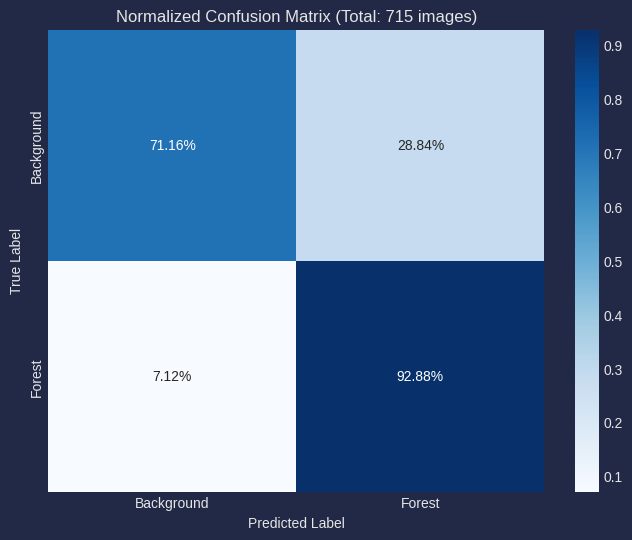

In [37]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)

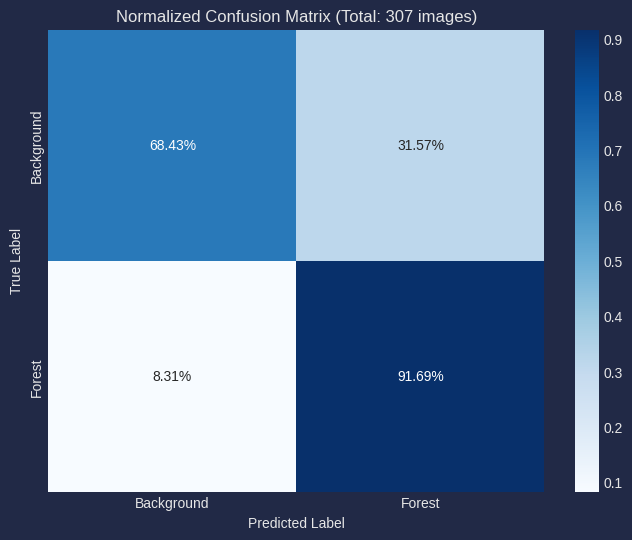

In [38]:
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

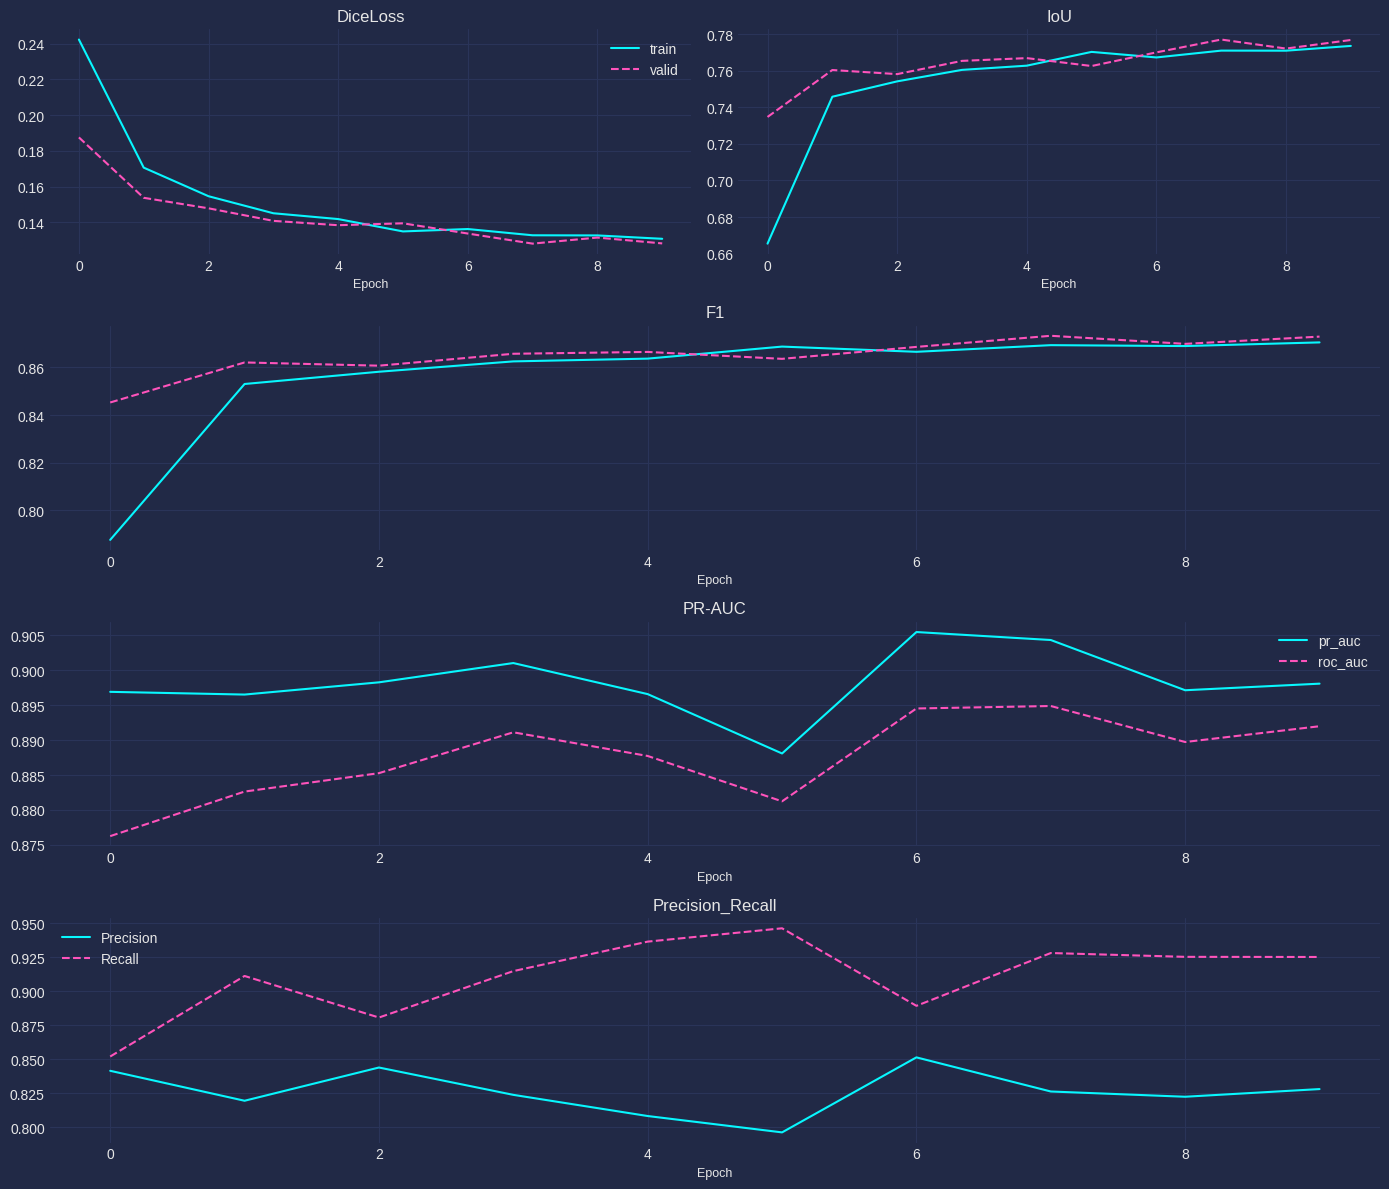

In [39]:
plot_logs(history_all['Unet_ResNet_mod'])

Картина улучшилась в части объектов, но в части фона увеличилась ошибка

Используем efficientnet-b3

In [40]:
# model = None
# model2 = None

In [41]:
torch.cuda.empty_cache()

In [42]:
# Создаем модель efficientnet-b3
model = smp.Unet(
    encoder_name="efficientnet-b3", # Меняем resnet34 на efficientnet-b3
    encoder_weights="imagenet",     # Веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (объект / фон)
    activation=None                 # Без активации (для использования BCEWithLogitsLoss или DiceLoss)
)
# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [43]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

In [44]:
config

{'batch_size': 16,
 'learning_rate': 0.0001,
 'epochs': 10,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [45]:
config['batch_size'] = 16

In [46]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_EfiNet_Forest_v1'
)

Epoch 1/10 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.74it/s, f1=0.8691, iou=0.7685, loss=0.1599]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2475 | IoU: 0.6568 | F1: 0.7818
Valid -> Loss: 0.1705 | IoU: 0.7663 | F1: 0.8665
Metrics -> Precision: 0.8287 | Recall: 0.9107 | ROC AUC: 0.8764 | PR AUC: 0.8833
Learning Rate: 0.0001



Epoch 2/10 [Train]: 100%|██████████| 256/256 [00:53<00:00,  4.75it/s, f1=0.8016, iou=0.6689, loss=0.2192]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1627 | IoU: 0.7545 | F1: 0.8585
Valid -> Loss: 0.1457 | IoU: 0.7673 | F1: 0.8670
Metrics -> Precision: 0.8597 | Recall: 0.8767 | ROC AUC: 0.8857 | PR AUC: 0.8954
Learning Rate: 0.0001



Epoch 3/10 [Train]: 100%|██████████| 256/256 [00:53<00:00,  4.74it/s, f1=0.8181, iou=0.6922, loss=0.1821]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1435 | IoU: 0.7690 | F1: 0.8679
Valid -> Loss: 0.1329 | IoU: 0.7804 | F1: 0.8754
Metrics -> Precision: 0.8499 | Recall: 0.9051 | ROC AUC: 0.8894 | PR AUC: 0.8979
Learning Rate: 0.0001



Epoch 4/10 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.72it/s, f1=0.8316, iou=0.7118, loss=0.1744]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1376 | IoU: 0.7717 | F1: 0.8696
Valid -> Loss: 0.1322 | IoU: 0.7759 | F1: 0.8724
Metrics -> Precision: 0.8437 | Recall: 0.9056 | ROC AUC: 0.8836 | PR AUC: 0.8937
Learning Rate: 0.0001



Epoch 5/10 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.74it/s, f1=0.8004, iou=0.6672, loss=0.1982]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1290 | IoU: 0.7810 | F1: 0.8755
Valid -> Loss: 0.1222 | IoU: 0.7889 | F1: 0.8808
Metrics -> Precision: 0.8467 | Recall: 0.9201 | ROC AUC: 0.8880 | PR AUC: 0.8948
Learning Rate: 0.0001



Epoch 6/10 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.73it/s, f1=0.9189, iou=0.8499, loss=0.0837]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1234 | IoU: 0.7873 | F1: 0.8799
Valid -> Loss: 0.1227 | IoU: 0.7875 | F1: 0.8800
Metrics -> Precision: 0.8512 | Recall: 0.9134 | ROC AUC: 0.8917 | PR AUC: 0.8987
Learning Rate: 0.0001



Epoch 7/10 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.74it/s, f1=0.8511, iou=0.7408, loss=0.1489]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1180 | IoU: 0.7949 | F1: 0.8845
Valid -> Loss: 0.1214 | IoU: 0.7881 | F1: 0.8803
Metrics -> Precision: 0.8522 | Recall: 0.9122 | ROC AUC: 0.8874 | PR AUC: 0.8983
Learning Rate: 0.0001



Epoch 8/10 [Train]: 100%|██████████| 256/256 [00:53<00:00,  4.74it/s, f1=0.8368, iou=0.7193, loss=0.1665]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1155 | IoU: 0.7979 | F1: 0.8865
Valid -> Loss: 0.1197 | IoU: 0.7900 | F1: 0.8815
Metrics -> Precision: 0.8562 | Recall: 0.9107 | ROC AUC: 0.8901 | PR AUC: 0.9013
Learning Rate: 0.0001



Epoch 9/10 [Train]: 100%|██████████| 256/256 [00:53<00:00,  4.75it/s, f1=0.9167, iou=0.8461, loss=0.0843]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1114 | IoU: 0.8041 | F1: 0.8901
Valid -> Loss: 0.1249 | IoU: 0.7820 | F1: 0.8761
Metrics -> Precision: 0.8532 | Recall: 0.9029 | ROC AUC: 0.8854 | PR AUC: 0.8882
Learning Rate: 0.0001



Epoch 10/10 [Train]: 100%|██████████| 256/256 [00:53<00:00,  4.74it/s, f1=0.8311, iou=0.7110, loss=0.1721]
2026/02/19 23:47:01 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1093 | IoU: 0.8068 | F1: 0.8919
Valid -> Loss: 0.1271 | IoU: 0.7782 | F1: 0.8738
Metrics -> Precision: 0.8408 | Recall: 0.9122 | ROC AUC: 0.8828 | PR AUC: 0.8842
Learning Rate: 0.0001



In [47]:
history_all['Unet_EfiNet_base'] = history

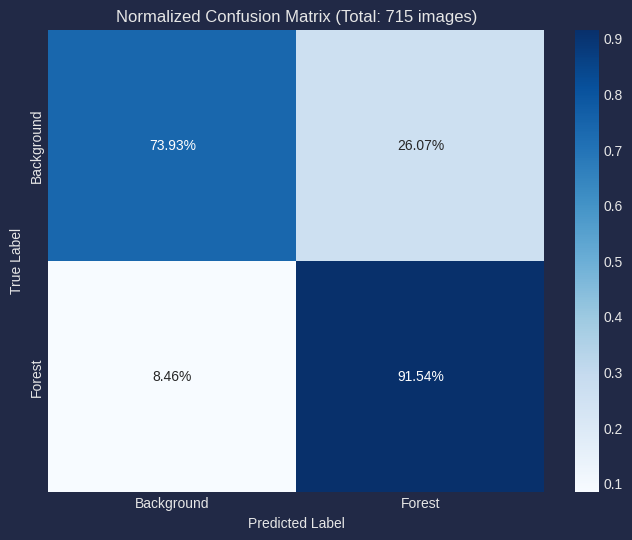

In [48]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)

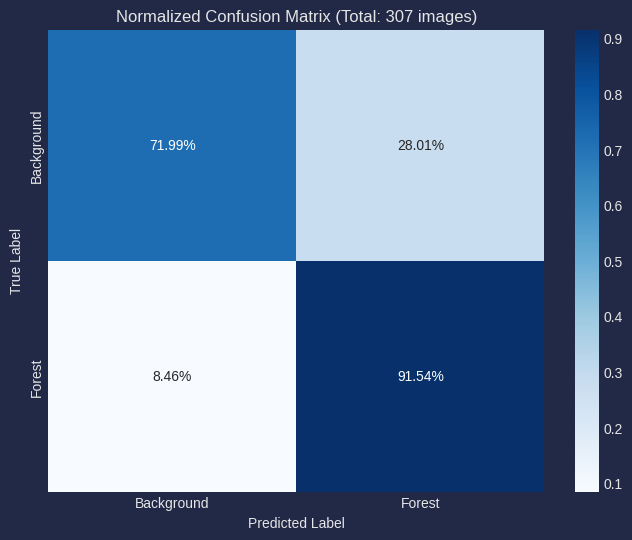

In [49]:
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

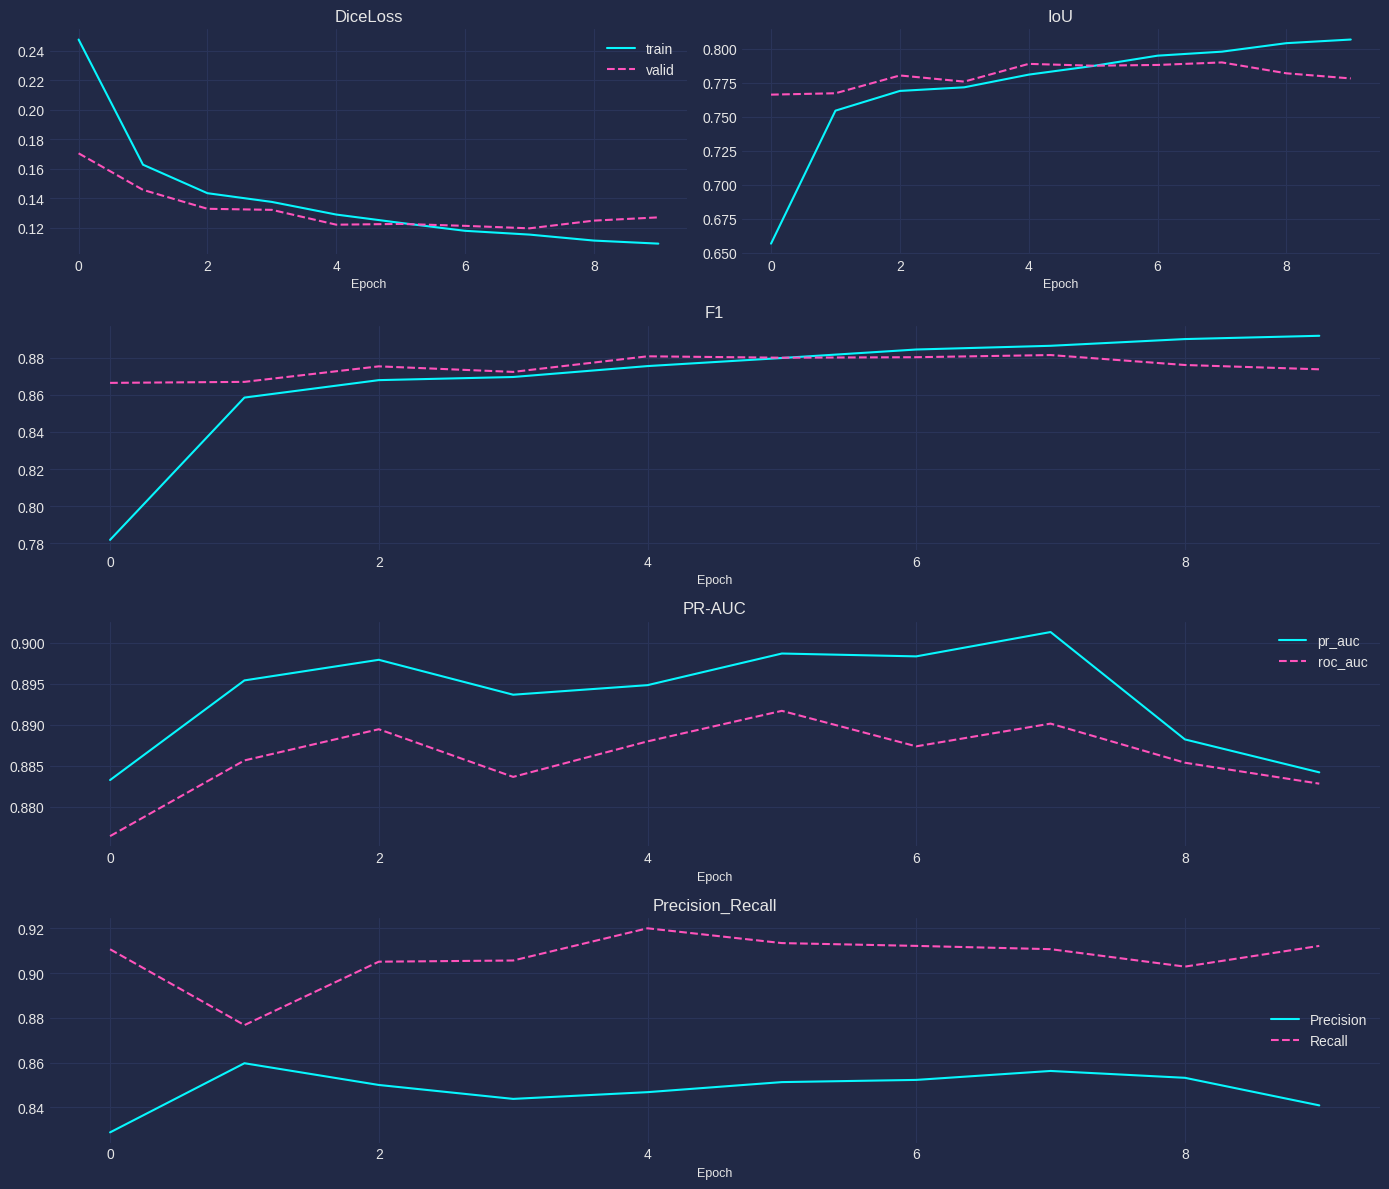

In [50]:
plot_logs(history_all['Unet_EfiNet_base'])

Скорректируем критерий и оптмайзер

In [51]:
model = smp.Unet(
    encoder_name="efficientnet-b3", # Меняем resnet34 на efficientnet-b3
    encoder_weights="imagenet",     # Веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (объект / фон)
    activation=None,                # Без активации (для использования BCEWithLogitsLoss или DiceLoss)
    decoder_attention_type='scse' 
)
# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [52]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary', smooth=1.0)

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'] * 0.5, # Делаем шаг поменьше
    weight_decay=0.05                 # Усиливаем регуляризацию
)

In [53]:
config

{'batch_size': 16,
 'learning_rate': 0.0001,
 'epochs': 10,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [54]:
config['epochs'] = 10

In [55]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_EfiNet_Forest_mod'
)

Epoch 1/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8390, iou=0.7227, loss=0.1875]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.3485 | IoU: 0.4332 | F1: 0.5754
Valid -> Loss: 0.2372 | IoU: 0.6576 | F1: 0.7918
Metrics -> Precision: 0.8456 | Recall: 0.7481 | ROC AUC: 0.8576 | PR AUC: 0.8708
Learning Rate: 5e-05



Epoch 2/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9251, iou=0.8606, loss=0.1301]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.2156 | IoU: 0.7103 | F1: 0.8286
Valid -> Loss: 0.1792 | IoU: 0.7600 | F1: 0.8622
Metrics -> Precision: 0.8433 | Recall: 0.8845 | ROC AUC: 0.8778 | PR AUC: 0.8832
Learning Rate: 5e-05



Epoch 3/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8894, iou=0.8009, loss=0.1413]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1746 | IoU: 0.7544 | F1: 0.8588
Valid -> Loss: 0.1590 | IoU: 0.7729 | F1: 0.8705
Metrics -> Precision: 0.8446 | Recall: 0.9003 | ROC AUC: 0.8847 | PR AUC: 0.8895
Learning Rate: 5e-05



Epoch 4/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8367, iou=0.7192, loss=0.1760]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1548 | IoU: 0.7670 | F1: 0.8670
Valid -> Loss: 0.1458 | IoU: 0.7734 | F1: 0.8707
Metrics -> Precision: 0.8528 | Recall: 0.8915 | ROC AUC: 0.8842 | PR AUC: 0.8953
Learning Rate: 5e-05



Epoch 5/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.5834, iou=0.4118, loss=0.4224]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1444 | IoU: 0.7725 | F1: 0.8702
Valid -> Loss: 0.1387 | IoU: 0.7787 | F1: 0.8740
Metrics -> Precision: 0.8432 | Recall: 0.9092 | ROC AUC: 0.8835 | PR AUC: 0.8904
Learning Rate: 5e-05



Epoch 6/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9075, iou=0.8306, loss=0.1025]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1369 | IoU: 0.7780 | F1: 0.8738
Valid -> Loss: 0.1307 | IoU: 0.7844 | F1: 0.8778
Metrics -> Precision: 0.8474 | Recall: 0.9126 | ROC AUC: 0.8848 | PR AUC: 0.8926
Learning Rate: 5e-05



Epoch 7/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.9019, iou=0.8213, loss=0.1047]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1307 | IoU: 0.7835 | F1: 0.8772
Valid -> Loss: 0.1292 | IoU: 0.7845 | F1: 0.8777
Metrics -> Precision: 0.8394 | Recall: 0.9219 | ROC AUC: 0.8859 | PR AUC: 0.8895
Learning Rate: 5e-05



Epoch 8/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9285, iou=0.8666, loss=0.0777]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1233 | IoU: 0.7924 | F1: 0.8829
Valid -> Loss: 0.1281 | IoU: 0.7839 | F1: 0.8774
Metrics -> Precision: 0.8469 | Recall: 0.9125 | ROC AUC: 0.8853 | PR AUC: 0.8927
Learning Rate: 5e-05



Epoch 9/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8937, iou=0.8078, loss=0.1120]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1212 | IoU: 0.7934 | F1: 0.8836
Valid -> Loss: 0.1271 | IoU: 0.7855 | F1: 0.8785
Metrics -> Precision: 0.8372 | Recall: 0.9263 | ROC AUC: 0.8870 | PR AUC: 0.8882
Learning Rate: 5e-05



Epoch 10/10 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9461, iou=0.8977, loss=0.0596]
2026/02/20 00:00:58 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1187 | IoU: 0.7959 | F1: 0.8850
Valid -> Loss: 0.1269 | IoU: 0.7822 | F1: 0.8763
Metrics -> Precision: 0.8493 | Recall: 0.9071 | ROC AUC: 0.8872 | PR AUC: 0.8938
Learning Rate: 5e-05



In [56]:
history_all['Unet_EfiNet_mod'] = history

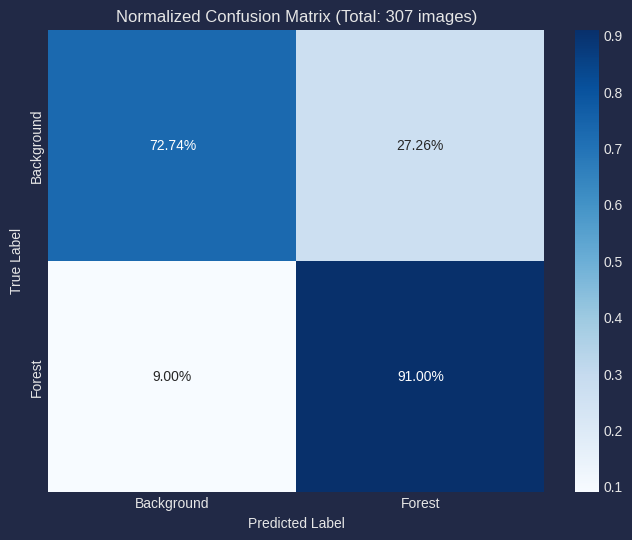

In [57]:
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

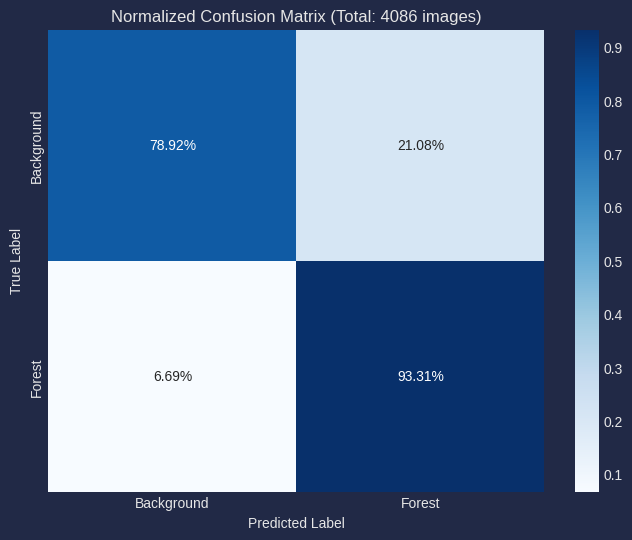

In [58]:
plot_segmentation_confusion_matrix(model, train_loader, DEVICE)

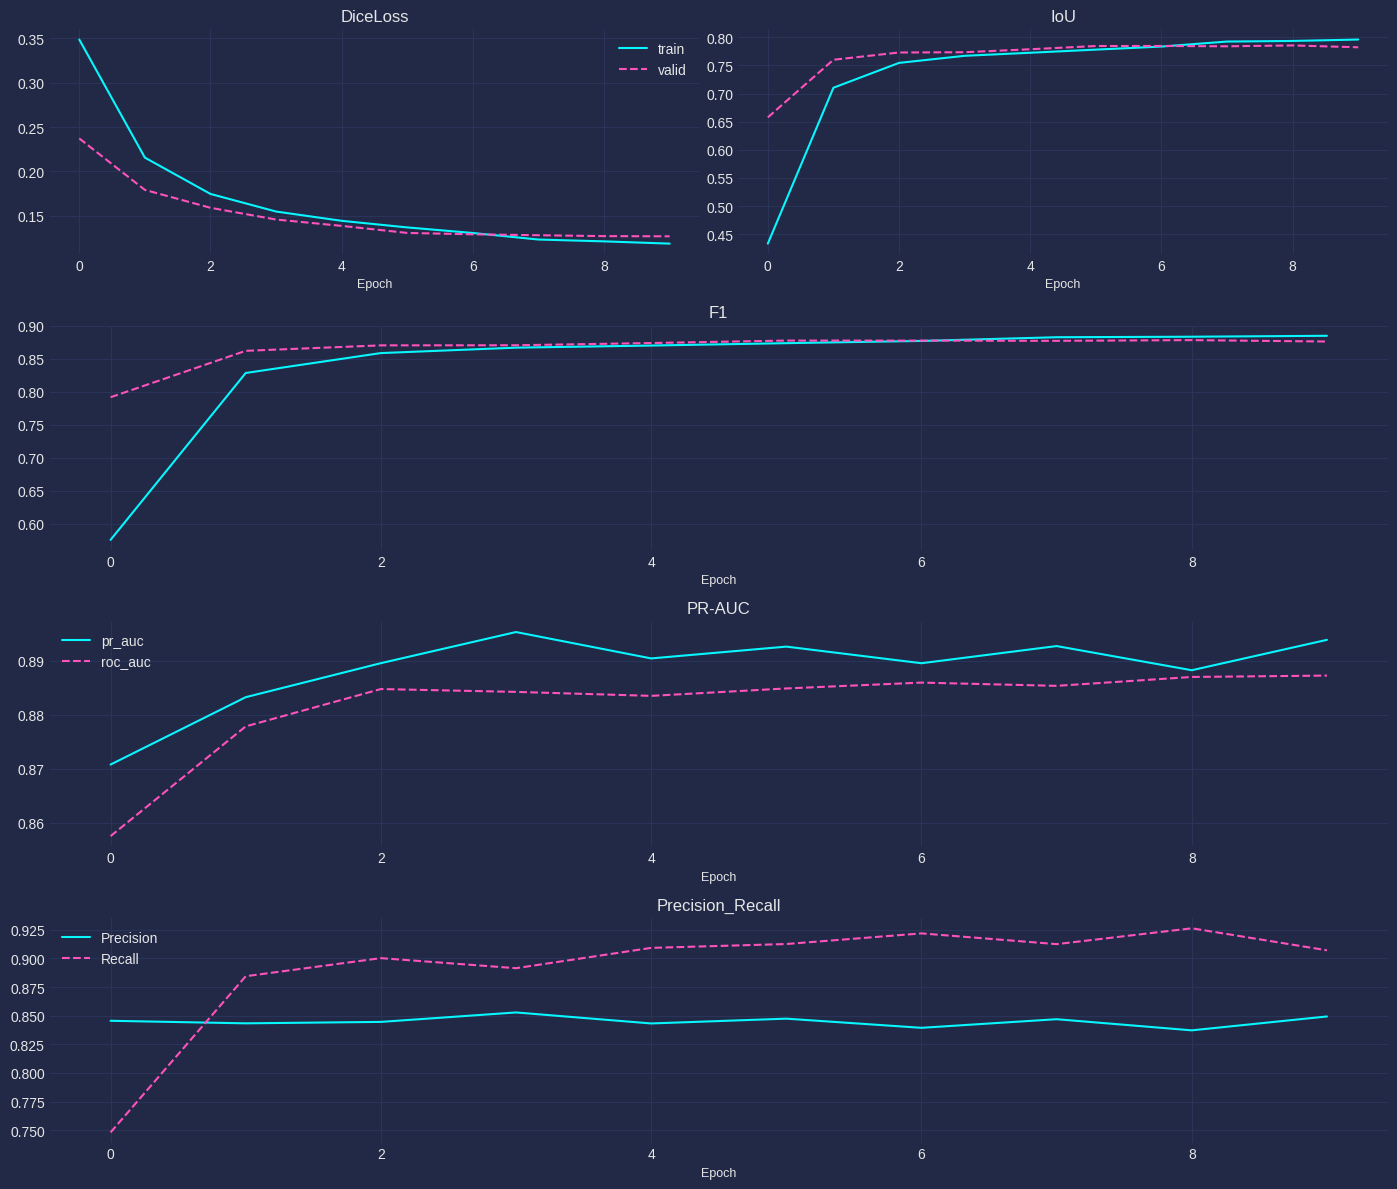

In [59]:
plot_logs(history_all['Unet_EfiNet_mod'])

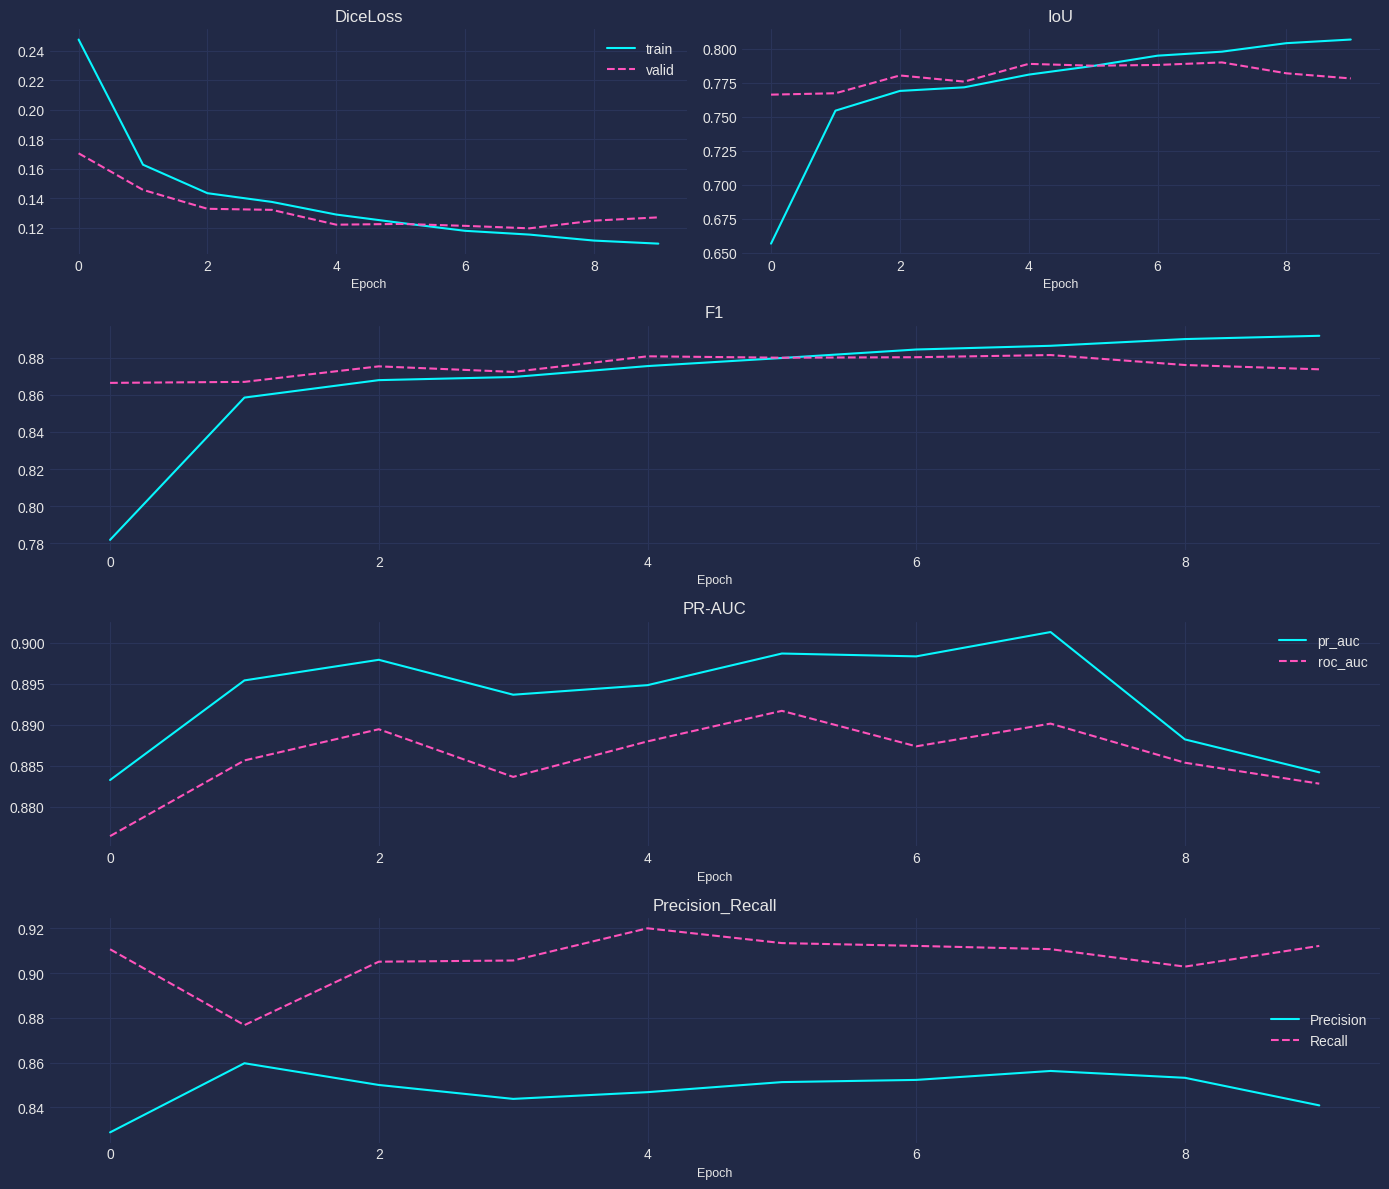

In [60]:
plot_logs(history_all['Unet_EfiNet_base'])

In [61]:

def inference_overlay(model, image_tensor, original_image, device='cuda', threshold=0.5):
    """
    image_tensor: подготовленный тензор [1, C, H, W]
    original_image: исходное изображение (numpy array) для отрисовки
    """
    model.eval()
    with torch.no_grad():
        # Получаем предсказание
        output = model(image_tensor.to(device))
        # Если на выходе сигмоида, берем значения > порога
        mask = (output > threshold).float().cpu().numpy()[0, 0] 

    plt.figure(figsize=(10, 10))
    plt.imshow(original_image) # Рисуем оригинал
    
    # Накладываем маску с прозрачностью (alpha)
    # Создаем маску, где фон — прозрачный (None), а объект — цветной
    masked_overlay = np.ma.masked_where(mask == 0, mask)
    
    plt.imshow(masked_overlay, cmap='spring', alpha=0.5) # 'spring', 'cool' или 'jet'
    plt.axis('off')
    plt.title(f"Inference (threshold: {threshold})")
    plt.show()

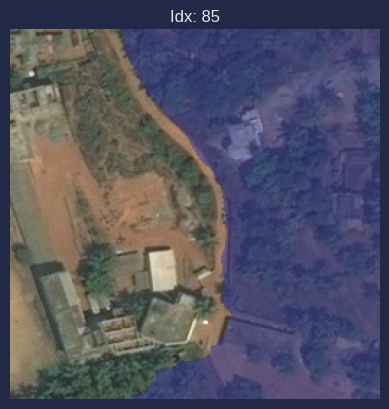

In [71]:
def show_pred(model, dataset):
    idx = random.randint(0, len(dataset)-1)
    img_t, mask_t = dataset[idx]
    
    model.eval()
    with torch.no_grad():
        pred = model(img_t.unsqueeze(0).to(DEVICE))
        pred = (pred.sigmoid() > 0.4).cpu().squeeze().numpy() # в numpy

    # СКРЫВАЕМ ФОН: говорим не рисовать там, где pred == 0
    pred_masked = np.ma.masked_where(pred == 0, pred)

    img_vis = (img_t.permute(1, 2, 0) * 0.225 + 0.456).clamp(0, 1).cpu()

    plt.imshow(img_vis)
    # Рисуем только замаскированную часть
    plt.imshow(pred_masked, alpha=0.5, cmap='terrain') 
    plt.title(f"Idx: {idx}")
    plt.axis('off')
    plt.show()

# Вызов:
show_pred(model, test_dataset)

In [72]:
model = smp.Unet(
    encoder_name="efficientnet-b3", # Меняем resnet34 на efficientnet-b3
    encoder_weights="imagenet",     # Веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (объект / фон)
    activation=None,                # Без активации (для использования BCEWithLogitsLoss или DiceLoss)
    decoder_attention_type='scse' 
)
# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [73]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary', smooth=1.0)

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'] * 0.5, # Делаем шаг поменьше
    weight_decay=0.05                 # Усиливаем регуляризацию
)

In [74]:
config

{'batch_size': 16,
 'learning_rate': 0.0001,
 'epochs': 10,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [75]:
config['epochs'] = 20

In [76]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_EfiNet_Forest_mod_e20'
)

Epoch 1/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8063, iou=0.6754, loss=0.2606]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2907 | IoU: 0.6180 | F1: 0.7540
Valid -> Loss: 0.2056 | IoU: 0.7530 | F1: 0.8577
Metrics -> Precision: 0.8014 | Recall: 0.9258 | ROC AUC: 0.8519 | PR AUC: 0.8546
Learning Rate: 5e-05



Epoch 2/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8293, iou=0.7084, loss=0.2029]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1884 | IoU: 0.7513 | F1: 0.8564
Valid -> Loss: 0.1668 | IoU: 0.7680 | F1: 0.8674
Metrics -> Precision: 0.8302 | Recall: 0.9109 | ROC AUC: 0.8714 | PR AUC: 0.8763
Learning Rate: 5e-05



Epoch 3/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9438, iou=0.8936, loss=0.0797]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1603 | IoU: 0.7651 | F1: 0.8655
Valid -> Loss: 0.1460 | IoU: 0.7776 | F1: 0.8736
Metrics -> Precision: 0.8354 | Recall: 0.9182 | ROC AUC: 0.8805 | PR AUC: 0.8852
Learning Rate: 5e-05



Epoch 4/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9235, iou=0.8579, loss=0.0909]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1472 | IoU: 0.7707 | F1: 0.8692
Valid -> Loss: 0.1373 | IoU: 0.7811 | F1: 0.8758
Metrics -> Precision: 0.8314 | Recall: 0.9279 | ROC AUC: 0.8821 | PR AUC: 0.8846
Learning Rate: 5e-05



Epoch 5/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8927, iou=0.8062, loss=0.1163]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1383 | IoU: 0.7767 | F1: 0.8729
Valid -> Loss: 0.1298 | IoU: 0.7863 | F1: 0.8791
Metrics -> Precision: 0.8410 | Recall: 0.9231 | ROC AUC: 0.8846 | PR AUC: 0.8847
Learning Rate: 5e-05



Epoch 6/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.9507, iou=0.9061, loss=0.0589]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1321 | IoU: 0.7812 | F1: 0.8760
Valid -> Loss: 0.1268 | IoU: 0.7870 | F1: 0.8797
Metrics -> Precision: 0.8434 | Recall: 0.9212 | ROC AUC: 0.8827 | PR AUC: 0.8810
Learning Rate: 5e-05



Epoch 7/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8908, iou=0.8030, loss=0.1168]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1264 | IoU: 0.7872 | F1: 0.8796
Valid -> Loss: 0.1253 | IoU: 0.7870 | F1: 0.8796
Metrics -> Precision: 0.8410 | Recall: 0.9241 | ROC AUC: 0.8822 | PR AUC: 0.8800
Learning Rate: 5e-05



Epoch 8/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.9447, iou=0.8953, loss=0.0601]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1215 | IoU: 0.7929 | F1: 0.8830
Valid -> Loss: 0.1235 | IoU: 0.7882 | F1: 0.8802
Metrics -> Precision: 0.8400 | Recall: 0.9268 | ROC AUC: 0.8858 | PR AUC: 0.8831
Learning Rate: 5e-05



Epoch 9/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.7496, iou=0.5994, loss=0.2531]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1177 | IoU: 0.7968 | F1: 0.8858
Valid -> Loss: 0.1235 | IoU: 0.7865 | F1: 0.8791
Metrics -> Precision: 0.8434 | Recall: 0.9203 | ROC AUC: 0.8841 | PR AUC: 0.8827
Learning Rate: 5e-05



Epoch 10/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.9210, iou=0.8536, loss=0.0811]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1159 | IoU: 0.7990 | F1: 0.8869
Valid -> Loss: 0.1257 | IoU: 0.7822 | F1: 0.8765
Metrics -> Precision: 0.8589 | Recall: 0.8976 | ROC AUC: 0.8877 | PR AUC: 0.8874
Learning Rate: 5e-05



Epoch 11/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8485, iou=0.7369, loss=0.1524]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.1112 | IoU: 0.8055 | F1: 0.8910
Valid -> Loss: 0.1248 | IoU: 0.7829 | F1: 0.8767
Metrics -> Precision: 0.8686 | Recall: 0.8871 | ROC AUC: 0.8907 | PR AUC: 0.8919
Learning Rate: 2.5e-05



Epoch 12/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9047, iou=0.8260, loss=0.0983]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.1090 | IoU: 0.8086 | F1: 0.8930
Valid -> Loss: 0.1235 | IoU: 0.7847 | F1: 0.8781
Metrics -> Precision: 0.8522 | Recall: 0.9076 | ROC AUC: 0.8875 | PR AUC: 0.8871
Learning Rate: 2.5e-05



Epoch 13/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.8806, iou=0.7867, loss=0.1215]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.1076 | IoU: 0.8113 | F1: 0.8943
Valid -> Loss: 0.1244 | IoU: 0.7831 | F1: 0.8769
Metrics -> Precision: 0.8522 | Recall: 0.9052 | ROC AUC: 0.8825 | PR AUC: 0.8811
Learning Rate: 2.5e-05



Epoch 14/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9129, iou=0.8398, loss=0.0883]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.1021 | IoU: 0.8188 | F1: 0.8995
Valid -> Loss: 0.1231 | IoU: 0.7849 | F1: 0.8782
Metrics -> Precision: 0.8547 | Recall: 0.9050 | ROC AUC: 0.8842 | PR AUC: 0.8804
Learning Rate: 2.5e-05



Epoch 15/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9025, iou=0.8224, loss=0.0987]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.1020 | IoU: 0.8190 | F1: 0.8995
Valid -> Loss: 0.1196 | IoU: 0.7899 | F1: 0.8814
Metrics -> Precision: 0.8509 | Recall: 0.9161 | ROC AUC: 0.8809 | PR AUC: 0.8763
Learning Rate: 2.5e-05



Epoch 16/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8942, iou=0.8086, loss=0.1068]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.1016 | IoU: 0.8196 | F1: 0.8997
Valid -> Loss: 0.1249 | IoU: 0.7818 | F1: 0.8762
Metrics -> Precision: 0.8551 | Recall: 0.9002 | ROC AUC: 0.8837 | PR AUC: 0.8786
Learning Rate: 2.5e-05



Epoch 17/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8678, iou=0.7665, loss=0.1330]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.0994 | IoU: 0.8227 | F1: 0.9018
Valid -> Loss: 0.1222 | IoU: 0.7855 | F1: 0.8786
Metrics -> Precision: 0.8532 | Recall: 0.9075 | ROC AUC: 0.8871 | PR AUC: 0.8842
Learning Rate: 2.5e-05



Epoch 18/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8699, iou=0.7698, loss=0.1305]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.1005 | IoU: 0.8208 | F1: 0.9006
Valid -> Loss: 0.1215 | IoU: 0.7867 | F1: 0.8793
Metrics -> Precision: 0.8449 | Recall: 0.9185 | ROC AUC: 0.8845 | PR AUC: 0.8804
Learning Rate: 1.25e-05



Epoch 19/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8477, iou=0.7356, loss=0.1536]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.0956 | IoU: 0.8288 | F1: 0.9054
Valid -> Loss: 0.1229 | IoU: 0.7843 | F1: 0.8778
Metrics -> Precision: 0.8541 | Recall: 0.9047 | ROC AUC: 0.8909 | PR AUC: 0.8910
Learning Rate: 1.25e-05



Epoch 20/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8836, iou=0.7915, loss=0.1175]
2026/02/20 00:30:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.0966 | IoU: 0.8272 | F1: 0.9044
Valid -> Loss: 0.1212 | IoU: 0.7871 | F1: 0.8795
Metrics -> Precision: 0.8560 | Recall: 0.9062 | ROC AUC: 0.8929 | PR AUC: 0.8900
Learning Rate: 1.25e-05



In [77]:
history_all['Unet_EfiNet_mod_e20'] = history

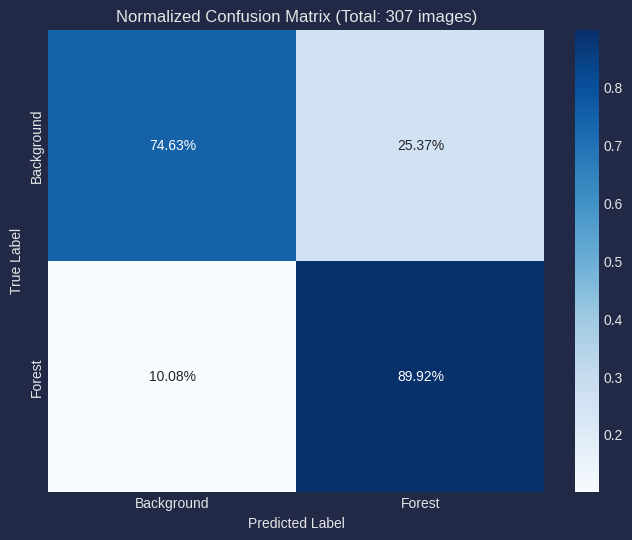

In [78]:
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

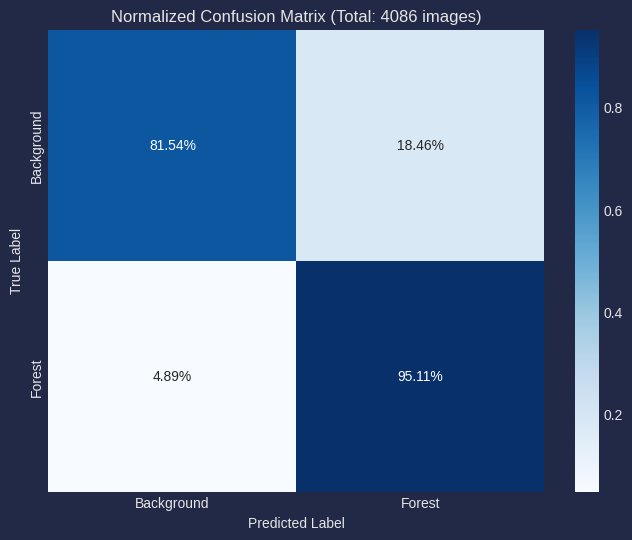

In [79]:
plot_segmentation_confusion_matrix(model, train_loader, DEVICE)

In [80]:
# Создаем модель
model = smp.Unet(
    encoder_name="resnet34",        # Энкодер (можно менять на resnet50, efficientnet-b0 и т.д.)
    encoder_weights="imagenet",     # Используем веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (лес / не лес)
    activation=None                 # Оставляем логиты (удобнее для функции потерь)
)

# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [81]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary', smooth=1.0)

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'] * 0.5, # Делаем шаг поменьше
    weight_decay=0.05                 # Усиливаем регуляризацию
)

In [82]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_ResNet34_Forest_mod_e20'
)

Epoch 1/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.09it/s, f1=0.8305, iou=0.7101, loss=0.2167]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2369 | IoU: 0.6801 | F1: 0.8038
Valid -> Loss: 0.1838 | IoU: 0.7506 | F1: 0.8560
Metrics -> Precision: 0.8473 | Recall: 0.8680 | ROC AUC: 0.8812 | PR AUC: 0.8911
Learning Rate: 5e-05



Epoch 2/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8068, iou=0.6762, loss=0.2303]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1765 | IoU: 0.7490 | F1: 0.8547
Valid -> Loss: 0.1621 | IoU: 0.7577 | F1: 0.8607
Metrics -> Precision: 0.8415 | Recall: 0.8838 | ROC AUC: 0.8824 | PR AUC: 0.8927
Learning Rate: 5e-05



Epoch 3/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.06it/s, f1=0.8738, iou=0.7759, loss=0.1354]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1596 | IoU: 0.7559 | F1: 0.8595
Valid -> Loss: 0.1698 | IoU: 0.7299 | F1: 0.8421
Metrics -> Precision: 0.8727 | Recall: 0.8166 | ROC AUC: 0.8818 | PR AUC: 0.8952
Learning Rate: 5e-05



Epoch 4/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8924, iou=0.8057, loss=0.1205]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1478 | IoU: 0.7649 | F1: 0.8653
Valid -> Loss: 0.1415 | IoU: 0.7721 | F1: 0.8703
Metrics -> Precision: 0.8199 | Recall: 0.9297 | ROC AUC: 0.8886 | PR AUC: 0.8959
Learning Rate: 5e-05



Epoch 5/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.12it/s, f1=0.9280, iou=0.8657, loss=0.0819]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1419 | IoU: 0.7685 | F1: 0.8676
Valid -> Loss: 0.1385 | IoU: 0.7709 | F1: 0.8694
Metrics -> Precision: 0.8269 | Recall: 0.9191 | ROC AUC: 0.8882 | PR AUC: 0.8969
Learning Rate: 5e-05



Epoch 6/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8862, iou=0.7957, loss=0.1178]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1369 | IoU: 0.7722 | F1: 0.8701
Valid -> Loss: 0.1361 | IoU: 0.7721 | F1: 0.8700
Metrics -> Precision: 0.8500 | Recall: 0.8935 | ROC AUC: 0.8935 | PR AUC: 0.9046
Learning Rate: 5e-05



Epoch 7/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.7498, iou=0.5997, loss=0.2524]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1323 | IoU: 0.7772 | F1: 0.8731
Valid -> Loss: 0.1333 | IoU: 0.7730 | F1: 0.8707
Metrics -> Precision: 0.8606 | Recall: 0.8836 | ROC AUC: 0.8958 | PR AUC: 0.9088
Learning Rate: 5e-05



Epoch 8/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.09it/s, f1=0.8158, iou=0.6889, loss=0.1860]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1307 | IoU: 0.7775 | F1: 0.8735
Valid -> Loss: 0.1325 | IoU: 0.7738 | F1: 0.8710
Metrics -> Precision: 0.8217 | Recall: 0.9296 | ROC AUC: 0.8882 | PR AUC: 0.8941
Learning Rate: 5e-05



Epoch 9/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.7557, iou=0.6074, loss=0.2506]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1286 | IoU: 0.7801 | F1: 0.8748
Valid -> Loss: 0.1332 | IoU: 0.7724 | F1: 0.8702
Metrics -> Precision: 0.8133 | Recall: 0.9385 | ROC AUC: 0.8892 | PR AUC: 0.9011
Learning Rate: 5e-05



Epoch 10/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.7295, iou=0.5742, loss=0.2732]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1271 | IoU: 0.7809 | F1: 0.8756
Valid -> Loss: 0.1280 | IoU: 0.7792 | F1: 0.8746
Metrics -> Precision: 0.8321 | Recall: 0.9242 | ROC AUC: 0.8916 | PR AUC: 0.8980
Learning Rate: 5e-05



Epoch 11/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.8549, iou=0.7465, loss=0.1471]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.1216 | IoU: 0.7889 | F1: 0.8806
Valid -> Loss: 0.1287 | IoU: 0.7773 | F1: 0.8732
Metrics -> Precision: 0.8579 | Recall: 0.8923 | ROC AUC: 0.8962 | PR AUC: 0.9100
Learning Rate: 5e-05



Epoch 12/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.8434, iou=0.7292, loss=0.1577]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.1215 | IoU: 0.7885 | F1: 0.8805
Valid -> Loss: 0.1261 | IoU: 0.7802 | F1: 0.8752
Metrics -> Precision: 0.8529 | Recall: 0.9016 | ROC AUC: 0.8966 | PR AUC: 0.9059
Learning Rate: 5e-05



Epoch 13/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.7336, iou=0.5792, loss=0.2676]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.1198 | IoU: 0.7909 | F1: 0.8818
Valid -> Loss: 0.1278 | IoU: 0.7782 | F1: 0.8739
Metrics -> Precision: 0.8390 | Recall: 0.9144 | ROC AUC: 0.8900 | PR AUC: 0.8954
Learning Rate: 5e-05



Epoch 14/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.8963, iou=0.8121, loss=0.1042]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.1160 | IoU: 0.7964 | F1: 0.8853
Valid -> Loss: 0.1207 | IoU: 0.7881 | F1: 0.8804
Metrics -> Precision: 0.8424 | Recall: 0.9243 | ROC AUC: 0.8908 | PR AUC: 0.8933
Learning Rate: 5e-05



Epoch 15/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.8195, iou=0.6942, loss=0.1813]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.1154 | IoU: 0.7969 | F1: 0.8858
Valid -> Loss: 0.1209 | IoU: 0.7881 | F1: 0.8802
Metrics -> Precision: 0.8404 | Recall: 0.9261 | ROC AUC: 0.8956 | PR AUC: 0.8997
Learning Rate: 5e-05



Epoch 16/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.10it/s, f1=0.9254, iou=0.8612, loss=0.0763]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.1159 | IoU: 0.7960 | F1: 0.8852
Valid -> Loss: 0.1319 | IoU: 0.7700 | F1: 0.8686
Metrics -> Precision: 0.8706 | Recall: 0.8693 | ROC AUC: 0.8984 | PR AUC: 0.9050
Learning Rate: 5e-05



Epoch 17/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.8808, iou=0.7870, loss=0.1194]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.1124 | IoU: 0.8013 | F1: 0.8885
Valid -> Loss: 0.1228 | IoU: 0.7844 | F1: 0.8778
Metrics -> Precision: 0.8422 | Recall: 0.9193 | ROC AUC: 0.8885 | PR AUC: 0.8913
Learning Rate: 2.5e-05



Epoch 18/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.8499, iou=0.7390, loss=0.1501]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.1068 | IoU: 0.8105 | F1: 0.8940
Valid -> Loss: 0.1201 | IoU: 0.7885 | F1: 0.8804
Metrics -> Precision: 0.8664 | Recall: 0.8974 | ROC AUC: 0.9019 | PR AUC: 0.9103
Learning Rate: 2.5e-05



Epoch 19/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.9184, iou=0.8491, loss=0.0845]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.1071 | IoU: 0.8099 | F1: 0.8936
Valid -> Loss: 0.1211 | IoU: 0.7867 | F1: 0.8794
Metrics -> Precision: 0.8455 | Recall: 0.9181 | ROC AUC: 0.8935 | PR AUC: 0.9036
Learning Rate: 2.5e-05



Epoch 20/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.11it/s, f1=0.9274, iou=0.8647, loss=0.0735]
2026/02/20 00:47:57 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.1036 | IoU: 0.8153 | F1: 0.8971
Valid -> Loss: 0.1265 | IoU: 0.7786 | F1: 0.8740
Metrics -> Precision: 0.8494 | Recall: 0.9020 | ROC AUC: 0.8922 | PR AUC: 0.8965
Learning Rate: 2.5e-05



In [83]:
history_all['Unet_ResNet_mod_e20'] = history

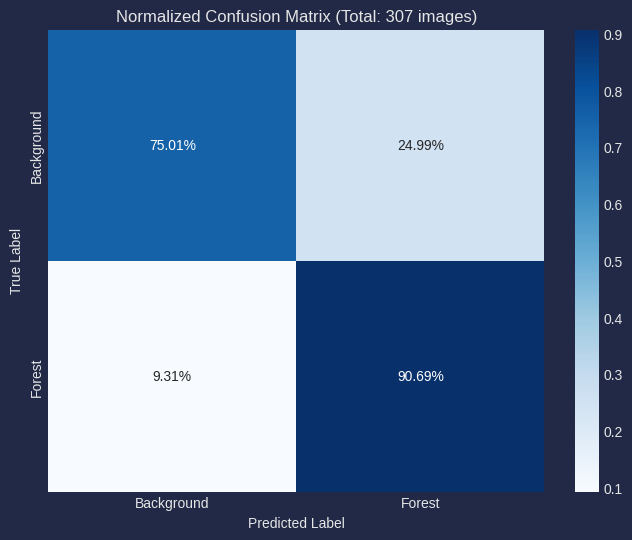

In [84]:
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

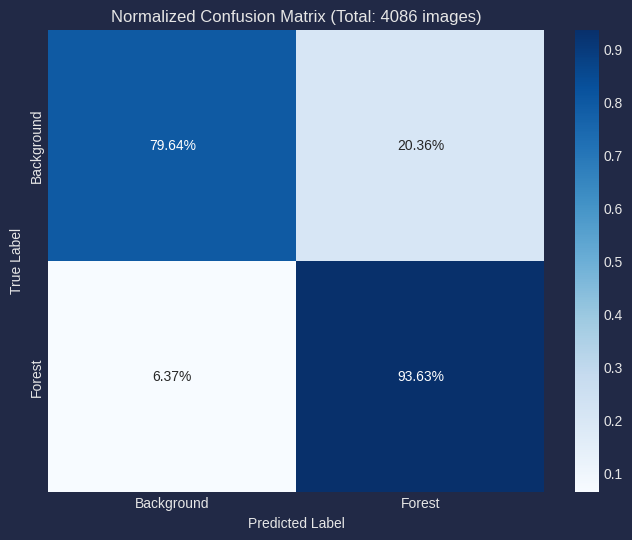

In [85]:
plot_segmentation_confusion_matrix(model, train_loader, DEVICE)

In [86]:
model = smp.MAnet(
    encoder_name="resnet34",        # Выбор энкодера (например, resnet, efficientnet)
    encoder_weights="imagenet",     # Использование предобученных весов ImageNet
    in_channels=3,                  # Количество входных каналов (3 для RGB)
    classes=1,                      # Количество классов на выходе (например, для бинарной маски)
    activation=None                 # Тип активации (None возвращает logits)
)
# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

MAnet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [87]:
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

# Создаем гибридную функцию (она будет вызываться внутри пайплайна)
def multi_criterion(preds, targets):
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)

# Оптимизатор (уже с твоим пониженным lr и регуляризацией)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate'], 
    weight_decay=0.02
)

In [88]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=multi_criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='MANet_ResNet_Forest_mod_e20_CRIT'
)

Epoch 1/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.9376, iou=0.8826, loss=0.2996]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.4246 | IoU: 0.6469 | F1: 0.7742
Valid -> Loss: 0.3780 | IoU: 0.7269 | F1: 0.8402
Metrics -> Precision: 0.8665 | Recall: 0.8186 | ROC AUC: 0.8954 | PR AUC: 0.9172
Learning Rate: 0.0001



Epoch 2/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.37it/s, f1=0.8480, iou=0.7361, loss=0.3725]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.3820 | IoU: 0.7363 | F1: 0.8466
Valid -> Loss: 0.3749 | IoU: 0.7621 | F1: 0.8635
Metrics -> Precision: 0.8306 | Recall: 0.9022 | ROC AUC: 0.8985 | PR AUC: 0.9193
Learning Rate: 0.0001



Epoch 3/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.39it/s, f1=0.8213, iou=0.6968, loss=0.4027]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.3766 | IoU: 0.7438 | F1: 0.8518
Valid -> Loss: 0.3770 | IoU: 0.7492 | F1: 0.8552
Metrics -> Precision: 0.8655 | Recall: 0.8482 | ROC AUC: 0.9018 | PR AUC: 0.9221
Learning Rate: 0.0001



Epoch 4/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.39it/s, f1=0.9115, iou=0.8373, loss=0.3322]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.3728 | IoU: 0.7496 | F1: 0.8554
Valid -> Loss: 0.3643 | IoU: 0.7707 | F1: 0.8691
Metrics -> Precision: 0.8454 | Recall: 0.8969 | ROC AUC: 0.9100 | PR AUC: 0.9300
Learning Rate: 0.0001



Epoch 5/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.39it/s, f1=0.7420, iou=0.5898, loss=0.5071]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.3694 | IoU: 0.7493 | F1: 0.8555
Valid -> Loss: 0.3582 | IoU: 0.7647 | F1: 0.8652
Metrics -> Precision: 0.8685 | Recall: 0.8649 | ROC AUC: 0.9128 | PR AUC: 0.9315
Learning Rate: 0.0001



Epoch 6/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.41it/s, f1=0.8710, iou=0.7714, loss=0.3687]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.3679 | IoU: 0.7547 | F1: 0.8590
Valid -> Loss: 0.3613 | IoU: 0.7584 | F1: 0.8610
Metrics -> Precision: 0.8641 | Recall: 0.8602 | ROC AUC: 0.9094 | PR AUC: 0.9293
Learning Rate: 0.0001



Epoch 7/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8767, iou=0.7805, loss=0.3369]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.3619 | IoU: 0.7639 | F1: 0.8648
Valid -> Loss: 0.3618 | IoU: 0.7532 | F1: 0.8576
Metrics -> Precision: 0.8746 | Recall: 0.8446 | ROC AUC: 0.9118 | PR AUC: 0.9337
Learning Rate: 0.0001



Epoch 8/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.9190, iou=0.8502, loss=0.3174]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.3624 | IoU: 0.7618 | F1: 0.8633
Valid -> Loss: 0.3671 | IoU: 0.7373 | F1: 0.8470
Metrics -> Precision: 0.8879 | Recall: 0.8129 | ROC AUC: 0.9112 | PR AUC: 0.9301
Learning Rate: 5e-05



Epoch 9/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.42it/s, f1=0.8976, iou=0.8143, loss=0.3214]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.3515 | IoU: 0.7782 | F1: 0.8739
Valid -> Loss: 0.3570 | IoU: 0.7545 | F1: 0.8585
Metrics -> Precision: 0.8911 | Recall: 0.8312 | ROC AUC: 0.9199 | PR AUC: 0.9375
Learning Rate: 5e-05



Epoch 10/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.41it/s, f1=0.8227, iou=0.6988, loss=0.4316]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.3479 | IoU: 0.7809 | F1: 0.8759
Valid -> Loss: 0.3536 | IoU: 0.7696 | F1: 0.8683
Metrics -> Precision: 0.8701 | Recall: 0.8689 | ROC AUC: 0.9176 | PR AUC: 0.9372
Learning Rate: 5e-05



Epoch 11/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8714, iou=0.7720, loss=0.3674]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.3476 | IoU: 0.7825 | F1: 0.8769
Valid -> Loss: 0.3579 | IoU: 0.7681 | F1: 0.8674
Metrics -> Precision: 0.8675 | Recall: 0.8697 | ROC AUC: 0.9158 | PR AUC: 0.9377
Learning Rate: 5e-05



Epoch 12/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8405, iou=0.7249, loss=0.3982]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.3462 | IoU: 0.7843 | F1: 0.8780
Valid -> Loss: 0.3492 | IoU: 0.7895 | F1: 0.8812
Metrics -> Precision: 0.8556 | Recall: 0.9110 | ROC AUC: 0.9266 | PR AUC: 0.9451
Learning Rate: 5e-05



Epoch 13/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8486, iou=0.7371, loss=0.3753]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.3419 | IoU: 0.7926 | F1: 0.8832
Valid -> Loss: 0.3495 | IoU: 0.7613 | F1: 0.8627
Metrics -> Precision: 0.8992 | Recall: 0.8320 | ROC AUC: 0.9269 | PR AUC: 0.9454
Learning Rate: 5e-05



Epoch 14/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8651, iou=0.7623, loss=0.3431]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.3415 | IoU: 0.7897 | F1: 0.8814
Valid -> Loss: 0.3480 | IoU: 0.7743 | F1: 0.8712
Metrics -> Precision: 0.8811 | Recall: 0.8642 | ROC AUC: 0.9235 | PR AUC: 0.9419
Learning Rate: 5e-05



Epoch 15/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.39it/s, f1=0.8857, iou=0.7948, loss=0.3392]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.3368 | IoU: 0.7964 | F1: 0.8857
Valid -> Loss: 0.3473 | IoU: 0.7757 | F1: 0.8719
Metrics -> Precision: 0.8834 | Recall: 0.8633 | ROC AUC: 0.9233 | PR AUC: 0.9412
Learning Rate: 5e-05



Epoch 16/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.41it/s, f1=0.8359, iou=0.7181, loss=0.3428]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.3333 | IoU: 0.8030 | F1: 0.8898
Valid -> Loss: 0.3502 | IoU: 0.7752 | F1: 0.8721
Metrics -> Precision: 0.8733 | Recall: 0.8735 | ROC AUC: 0.9221 | PR AUC: 0.9406
Learning Rate: 5e-05



Epoch 17/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8324, iou=0.7130, loss=0.4137]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.3332 | IoU: 0.8011 | F1: 0.8886
Valid -> Loss: 0.3503 | IoU: 0.7765 | F1: 0.8729
Metrics -> Precision: 0.8674 | Recall: 0.8809 | ROC AUC: 0.9229 | PR AUC: 0.9430
Learning Rate: 5e-05



Epoch 18/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.41it/s, f1=0.7842, iou=0.6450, loss=0.4628]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.3357 | IoU: 0.7985 | F1: 0.8869
Valid -> Loss: 0.3542 | IoU: 0.7652 | F1: 0.8659
Metrics -> Precision: 0.8795 | Recall: 0.8552 | ROC AUC: 0.9170 | PR AUC: 0.9365
Learning Rate: 2.5e-05



Epoch 19/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.40it/s, f1=0.8829, iou=0.7903, loss=0.3213]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.3341 | IoU: 0.8001 | F1: 0.8879
Valid -> Loss: 0.3516 | IoU: 0.7748 | F1: 0.8717
Metrics -> Precision: 0.8774 | Recall: 0.8691 | ROC AUC: 0.9204 | PR AUC: 0.9397
Learning Rate: 2.5e-05



Epoch 20/20 [Train]: 100%|██████████| 256/256 [00:34<00:00,  7.39it/s, f1=0.9143, iou=0.8420, loss=0.2925]
2026/02/20 01:06:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.3284 | IoU: 0.8079 | F1: 0.8925
Valid -> Loss: 0.3508 | IoU: 0.7865 | F1: 0.8793
Metrics -> Precision: 0.8591 | Recall: 0.9030 | ROC AUC: 0.9232 | PR AUC: 0.9428
Learning Rate: 2.5e-05



In [89]:
history_all['MANet_ResNet_mod_e20_crit'] = history

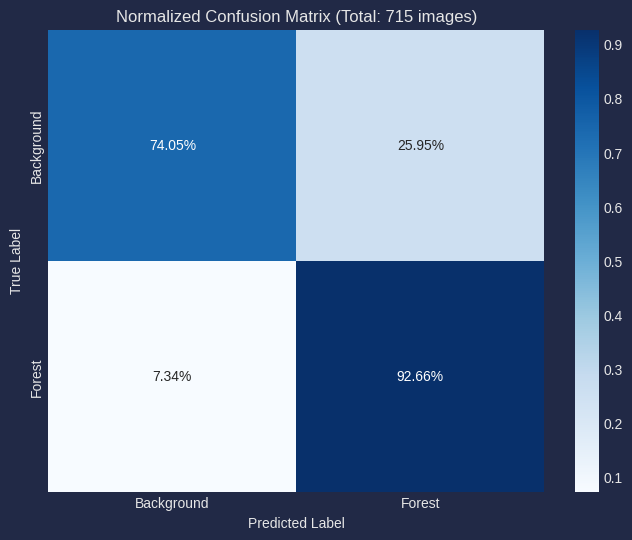

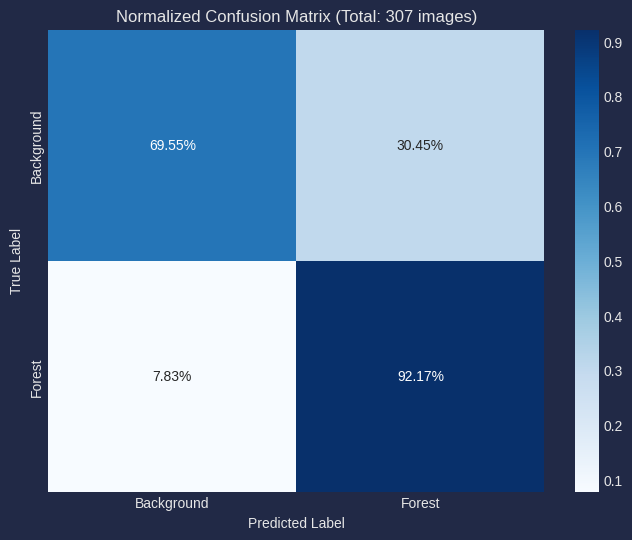

In [90]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

In [97]:
import torch
import gc

# 1. Удаляем модель или тензоры
# del model 
# del optimizer

# 2. Принудительно запускаем сборщик мусора Python
gc.collect()

# 3. Теперь очищаем кэш видеокарты
torch.cuda.empty_cache()

In [98]:
model = smp.MAnet(
    encoder_name="efficientnet-b3",        # Выбор энкодера (например, resnet, efficientnet)
    encoder_weights="imagenet",     # Использование предобученных весов ImageNet
    in_channels=3,                  # Количество входных каналов (3 для RGB)
    classes=1,                      # Количество классов на выходе (например, для бинарной маски)
    activation=None                 # Тип активации (None возвращает logits)
)
# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

MAnet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadd

In [99]:
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

# Создаем гибридную функцию (она будет вызываться внутри пайплайна)
def multi_criterion(preds, targets):
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)

# Оптимизатор (уже с твоим пониженным lr и регуляризацией)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate']*0.5, 
    weight_decay=0.05
)


In [100]:
config

{'batch_size': 8,
 'learning_rate': 0.0001,
 'epochs': 20,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [101]:
config['batch_size']=8

In [102]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=multi_criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='MANet_EfiNet_Forest_mod_e20_CRIT'
)

Epoch 1/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.66it/s, f1=0.7803, iou=0.6397, loss=0.4588]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.4864 | IoU: 0.4977 | F1: 0.6491
Valid -> Loss: 0.4024 | IoU: 0.6963 | F1: 0.8196
Metrics -> Precision: 0.8465 | Recall: 0.7974 | ROC AUC: 0.8672 | PR AUC: 0.8834
Learning Rate: 5e-05



Epoch 2/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.7526, iou=0.6033, loss=0.5035]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.3963 | IoU: 0.7097 | F1: 0.8289
Valid -> Loss: 0.3744 | IoU: 0.7380 | F1: 0.8480
Metrics -> Precision: 0.8657 | Recall: 0.8339 | ROC AUC: 0.8956 | PR AUC: 0.9116
Learning Rate: 5e-05



Epoch 3/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.6329, iou=0.4629, loss=0.6275]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.3809 | IoU: 0.7344 | F1: 0.8455
Valid -> Loss: 0.3694 | IoU: 0.7604 | F1: 0.8624
Metrics -> Precision: 0.8528 | Recall: 0.8749 | ROC AUC: 0.8984 | PR AUC: 0.9137
Learning Rate: 5e-05



Epoch 4/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.66it/s, f1=0.8134, iou=0.6855, loss=0.4101]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.3708 | IoU: 0.7522 | F1: 0.8573
Valid -> Loss: 0.3664 | IoU: 0.7624 | F1: 0.8639
Metrics -> Precision: 0.8602 | Recall: 0.8701 | ROC AUC: 0.9049 | PR AUC: 0.9225
Learning Rate: 5e-05



Epoch 5/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.66it/s, f1=0.8770, iou=0.7810, loss=0.3562]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.3634 | IoU: 0.7589 | F1: 0.8619
Valid -> Loss: 0.3616 | IoU: 0.7639 | F1: 0.8648
Metrics -> Precision: 0.8655 | Recall: 0.8663 | ROC AUC: 0.9079 | PR AUC: 0.9245
Learning Rate: 5e-05



Epoch 6/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.66it/s, f1=0.8272, iou=0.7054, loss=0.4233]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.3593 | IoU: 0.7663 | F1: 0.8667
Valid -> Loss: 0.3593 | IoU: 0.7559 | F1: 0.8597
Metrics -> Precision: 0.8807 | Recall: 0.8418 | ROC AUC: 0.9113 | PR AUC: 0.9291
Learning Rate: 5e-05



Epoch 7/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.8341, iou=0.7154, loss=0.3834]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.3560 | IoU: 0.7711 | F1: 0.8698
Valid -> Loss: 0.3613 | IoU: 0.7563 | F1: 0.8599
Metrics -> Precision: 0.8753 | Recall: 0.8471 | ROC AUC: 0.9109 | PR AUC: 0.9293
Learning Rate: 5e-05



Epoch 8/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8317, iou=0.7119, loss=0.4419]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.3508 | IoU: 0.7785 | F1: 0.8745
Valid -> Loss: 0.3574 | IoU: 0.7700 | F1: 0.8687
Metrics -> Precision: 0.8675 | Recall: 0.8721 | ROC AUC: 0.9136 | PR AUC: 0.9326
Learning Rate: 5e-05



Epoch 9/20 [Train]: 100%|██████████| 256/256 [00:55<00:00,  4.63it/s, f1=0.8807, iou=0.7868, loss=0.3453]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.3462 | IoU: 0.7850 | F1: 0.8786
Valid -> Loss: 0.3561 | IoU: 0.7737 | F1: 0.8710
Metrics -> Precision: 0.8682 | Recall: 0.8766 | ROC AUC: 0.9129 | PR AUC: 0.9298
Learning Rate: 5e-05



Epoch 10/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.66it/s, f1=0.8599, iou=0.7543, loss=0.3744]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.3473 | IoU: 0.7834 | F1: 0.8777
Valid -> Loss: 0.3592 | IoU: 0.7574 | F1: 0.8605
Metrics -> Precision: 0.8810 | Recall: 0.8432 | ROC AUC: 0.9138 | PR AUC: 0.9335
Learning Rate: 5e-05



Epoch 11/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8676, iou=0.7662, loss=0.3594]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.3376 | IoU: 0.7971 | F1: 0.8863
Valid -> Loss: 0.3675 | IoU: 0.7599 | F1: 0.8619
Metrics -> Precision: 0.8605 | Recall: 0.8656 | ROC AUC: 0.9029 | PR AUC: 0.9225
Learning Rate: 5e-05



Epoch 12/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8140, iou=0.6863, loss=0.4234]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.3380 | IoU: 0.7970 | F1: 0.8861
Valid -> Loss: 0.3646 | IoU: 0.7655 | F1: 0.8651
Metrics -> Precision: 0.8589 | Recall: 0.8736 | ROC AUC: 0.9101 | PR AUC: 0.9318
Learning Rate: 2.5e-05



Epoch 13/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8676, iou=0.7662, loss=0.3420]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.3314 | IoU: 0.8048 | F1: 0.8909
Valid -> Loss: 0.3584 | IoU: 0.7680 | F1: 0.8670
Metrics -> Precision: 0.8689 | Recall: 0.8674 | ROC AUC: 0.9134 | PR AUC: 0.9322
Learning Rate: 2.5e-05



Epoch 14/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.9354, iou=0.8786, loss=0.2819]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.3268 | IoU: 0.8130 | F1: 0.8960
Valid -> Loss: 0.3612 | IoU: 0.7654 | F1: 0.8654
Metrics -> Precision: 0.8678 | Recall: 0.8653 | ROC AUC: 0.9107 | PR AUC: 0.9298
Learning Rate: 2.5e-05



Epoch 15/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8441, iou=0.7302, loss=0.3759]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.3245 | IoU: 0.8151 | F1: 0.8972
Valid -> Loss: 0.3578 | IoU: 0.7659 | F1: 0.8658
Metrics -> Precision: 0.8783 | Recall: 0.8561 | ROC AUC: 0.9158 | PR AUC: 0.9339
Learning Rate: 1.25e-05



Epoch 16/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8722, iou=0.7733, loss=0.3501]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.3232 | IoU: 0.8171 | F1: 0.8986
Valid -> Loss: 0.3598 | IoU: 0.7652 | F1: 0.8652
Metrics -> Precision: 0.8719 | Recall: 0.8609 | ROC AUC: 0.9135 | PR AUC: 0.9329
Learning Rate: 1.25e-05



Epoch 17/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.6222, iou=0.4516, loss=0.6546]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.3233 | IoU: 0.8165 | F1: 0.8981
Valid -> Loss: 0.3604 | IoU: 0.7610 | F1: 0.8626
Metrics -> Precision: 0.8811 | Recall: 0.8470 | ROC AUC: 0.9152 | PR AUC: 0.9346
Learning Rate: 1.25e-05



Epoch 18/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8049, iou=0.6735, loss=0.4618]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.3211 | IoU: 0.8187 | F1: 0.8994
Valid -> Loss: 0.3576 | IoU: 0.7696 | F1: 0.8680
Metrics -> Precision: 0.8733 | Recall: 0.8649 | ROC AUC: 0.9161 | PR AUC: 0.9353
Learning Rate: 6.25e-06



Epoch 19/20 [Train]: 100%|██████████| 256/256 [00:55<00:00,  4.65it/s, f1=0.8703, iou=0.7703, loss=0.3816]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.3165 | IoU: 0.8261 | F1: 0.9040
Valid -> Loss: 0.3569 | IoU: 0.7743 | F1: 0.8712
Metrics -> Precision: 0.8664 | Recall: 0.8782 | ROC AUC: 0.9163 | PR AUC: 0.9355
Learning Rate: 6.25e-06



Epoch 20/20 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.8941, iou=0.8085, loss=0.2929]
2026/02/20 01:39:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.3171 | IoU: 0.8244 | F1: 0.9030
Valid -> Loss: 0.3574 | IoU: 0.7723 | F1: 0.8699
Metrics -> Precision: 0.8709 | Recall: 0.8710 | ROC AUC: 0.9176 | PR AUC: 0.9368
Learning Rate: 6.25e-06



In [103]:
history_all['MANet_EfiNet_mod_e20_crit'] = history

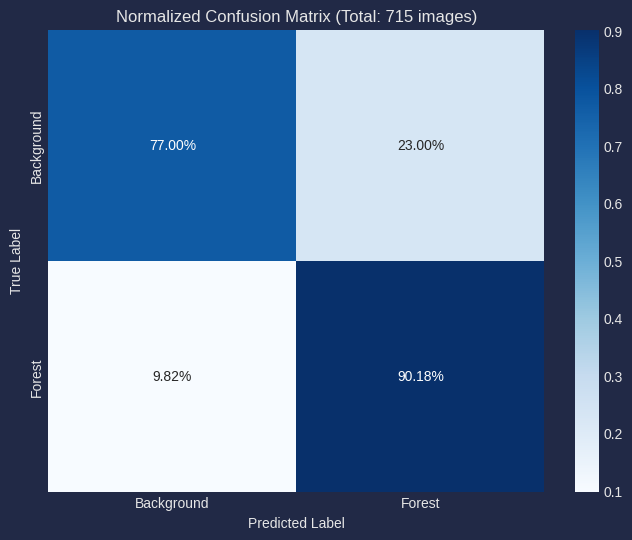

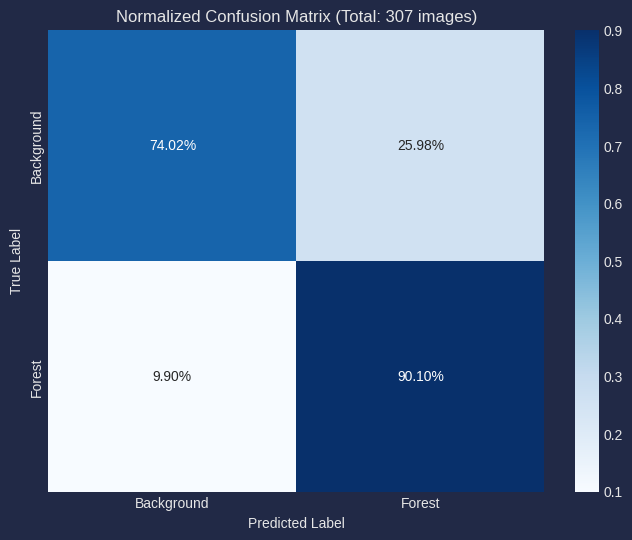

In [104]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

In [105]:
config['batch_size']=16

In [106]:
model = smp.Unet(
    encoder_name="efficientnet-b3", # Меняем resnet34 на efficientnet-b3
    encoder_weights="imagenet",     # Веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (объект / фон)
    activation=None,                # Без активации (для использования BCEWithLogitsLoss или DiceLoss)
    decoder_attention_type='scse' 
)
# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [107]:
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

# Создаем гибридную функцию (она будет вызываться внутри пайплайна)
def multi_criterion(preds, targets):
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)

# Оптимизатор (уже с твоим пониженным lr и регуляризацией)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate']*0.5, 
    weight_decay=0.05
)


In [108]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=multi_criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_EfiNet_Forest_mod_e20_CRIT_v2'
)

Epoch 1/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.6730, iou=0.5072, loss=0.5607]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.4762 | IoU: 0.5027 | F1: 0.6488
Valid -> Loss: 0.3893 | IoU: 0.7285 | F1: 0.8415
Metrics -> Precision: 0.8430 | Recall: 0.8428 | ROC AUC: 0.8746 | PR AUC: 0.8864
Learning Rate: 5e-05



Epoch 2/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.7721, iou=0.6288, loss=0.4681]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.3876 | IoU: 0.7223 | F1: 0.8373
Valid -> Loss: 0.3678 | IoU: 0.7579 | F1: 0.8609
Metrics -> Precision: 0.8603 | Recall: 0.8641 | ROC AUC: 0.8983 | PR AUC: 0.9112
Learning Rate: 5e-05



Epoch 3/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8653, iou=0.7625, loss=0.3545]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.3741 | IoU: 0.7460 | F1: 0.8531
Valid -> Loss: 0.3610 | IoU: 0.7684 | F1: 0.8676
Metrics -> Precision: 0.8585 | Recall: 0.8790 | ROC AUC: 0.9074 | PR AUC: 0.9227
Learning Rate: 5e-05



Epoch 4/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8113, iou=0.6825, loss=0.4366]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.3662 | IoU: 0.7556 | F1: 0.8597
Valid -> Loss: 0.3562 | IoU: 0.7725 | F1: 0.8702
Metrics -> Precision: 0.8632 | Recall: 0.8798 | ROC AUC: 0.9125 | PR AUC: 0.9264
Learning Rate: 5e-05



Epoch 5/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9549, iou=0.9137, loss=0.2608]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.3613 | IoU: 0.7645 | F1: 0.8652
Valid -> Loss: 0.3511 | IoU: 0.7741 | F1: 0.8713
Metrics -> Precision: 0.8744 | Recall: 0.8704 | ROC AUC: 0.9184 | PR AUC: 0.9337
Learning Rate: 5e-05



Epoch 6/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8827, iou=0.7900, loss=0.3544]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.3530 | IoU: 0.7735 | F1: 0.8712
Valid -> Loss: 0.3543 | IoU: 0.7761 | F1: 0.8727
Metrics -> Precision: 0.8679 | Recall: 0.8795 | ROC AUC: 0.9139 | PR AUC: 0.9293
Learning Rate: 5e-05



Epoch 7/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8246, iou=0.7016, loss=0.4147]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.3513 | IoU: 0.7773 | F1: 0.8735
Valid -> Loss: 0.3540 | IoU: 0.7743 | F1: 0.8713
Metrics -> Precision: 0.8711 | Recall: 0.8737 | ROC AUC: 0.9168 | PR AUC: 0.9332
Learning Rate: 5e-05



Epoch 8/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.8914, iou=0.8041, loss=0.3272]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.3454 | IoU: 0.7824 | F1: 0.8770
Valid -> Loss: 0.3507 | IoU: 0.7816 | F1: 0.8760
Metrics -> Precision: 0.8693 | Recall: 0.8849 | ROC AUC: 0.9196 | PR AUC: 0.9357
Learning Rate: 5e-05



Epoch 9/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8993, iou=0.8171, loss=0.3226]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.3374 | IoU: 0.7941 | F1: 0.8843
Valid -> Loss: 0.3525 | IoU: 0.7738 | F1: 0.8709
Metrics -> Precision: 0.8764 | Recall: 0.8681 | ROC AUC: 0.9188 | PR AUC: 0.9361
Learning Rate: 5e-05



Epoch 10/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.7582, iou=0.6105, loss=0.5111]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.3383 | IoU: 0.7958 | F1: 0.8851
Valid -> Loss: 0.3481 | IoU: 0.7835 | F1: 0.8772
Metrics -> Precision: 0.8739 | Recall: 0.8826 | ROC AUC: 0.9235 | PR AUC: 0.9397
Learning Rate: 5e-05



Epoch 11/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8498, iou=0.7388, loss=0.3705]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.3328 | IoU: 0.8013 | F1: 0.8889
Valid -> Loss: 0.3490 | IoU: 0.7742 | F1: 0.8710
Metrics -> Precision: 0.8822 | Recall: 0.8628 | ROC AUC: 0.9221 | PR AUC: 0.9399
Learning Rate: 5e-05



Epoch 12/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.8729, iou=0.7744, loss=0.3377]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.3288 | IoU: 0.8088 | F1: 0.8935
Valid -> Loss: 0.3578 | IoU: 0.7623 | F1: 0.8630
Metrics -> Precision: 0.8827 | Recall: 0.8469 | ROC AUC: 0.9158 | PR AUC: 0.9364
Learning Rate: 5e-05



Epoch 13/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.7969, iou=0.6624, loss=0.4571]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.3272 | IoU: 0.8103 | F1: 0.8943
Valid -> Loss: 0.3538 | IoU: 0.7749 | F1: 0.8718
Metrics -> Precision: 0.8754 | Recall: 0.8703 | ROC AUC: 0.9177 | PR AUC: 0.9348
Learning Rate: 2.5e-05



Epoch 14/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8512, iou=0.7409, loss=0.3441]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.3184 | IoU: 0.8226 | F1: 0.9021
Valid -> Loss: 0.3509 | IoU: 0.7743 | F1: 0.8714
Metrics -> Precision: 0.8879 | Recall: 0.8576 | ROC AUC: 0.9231 | PR AUC: 0.9404
Learning Rate: 2.5e-05



Epoch 15/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9322, iou=0.8731, loss=0.2773]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.3139 | IoU: 0.8272 | F1: 0.9048
Valid -> Loss: 0.3531 | IoU: 0.7693 | F1: 0.8681
Metrics -> Precision: 0.8807 | Recall: 0.8580 | ROC AUC: 0.9199 | PR AUC: 0.9388
Learning Rate: 2.5e-05



Epoch 16/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9176, iou=0.8478, loss=0.3065]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.3135 | IoU: 0.8303 | F1: 0.9067
Valid -> Loss: 0.3505 | IoU: 0.7783 | F1: 0.8739
Metrics -> Precision: 0.8747 | Recall: 0.8751 | ROC AUC: 0.9208 | PR AUC: 0.9380
Learning Rate: 1.25e-05



Epoch 17/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.18it/s, f1=0.9085, iou=0.8323, loss=0.3071]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.3075 | IoU: 0.8377 | F1: 0.9112
Valid -> Loss: 0.3497 | IoU: 0.7827 | F1: 0.8768
Metrics -> Precision: 0.8763 | Recall: 0.8795 | ROC AUC: 0.9218 | PR AUC: 0.9382
Learning Rate: 1.25e-05



Epoch 18/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.9036, iou=0.8241, loss=0.3053]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.3091 | IoU: 0.8354 | F1: 0.9097
Valid -> Loss: 0.3535 | IoU: 0.7767 | F1: 0.8729
Metrics -> Precision: 0.8764 | Recall: 0.8716 | ROC AUC: 0.9206 | PR AUC: 0.9380
Learning Rate: 1.25e-05



Epoch 19/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8563, iou=0.7488, loss=0.4168]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.3077 | IoU: 0.8382 | F1: 0.9114
Valid -> Loss: 0.3519 | IoU: 0.7812 | F1: 0.8758
Metrics -> Precision: 0.8794 | Recall: 0.8744 | ROC AUC: 0.9219 | PR AUC: 0.9389
Learning Rate: 6.25e-06



Epoch 20/20 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9458, iou=0.8972, loss=0.2614]
2026/02/20 02:07:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.3061 | IoU: 0.8400 | F1: 0.9125
Valid -> Loss: 0.3520 | IoU: 0.7796 | F1: 0.8747
Metrics -> Precision: 0.8759 | Recall: 0.8757 | ROC AUC: 0.9212 | PR AUC: 0.9387
Learning Rate: 6.25e-06



In [109]:
history_all['Unet_EfiNet_mod_e20_crit_v2'] = history

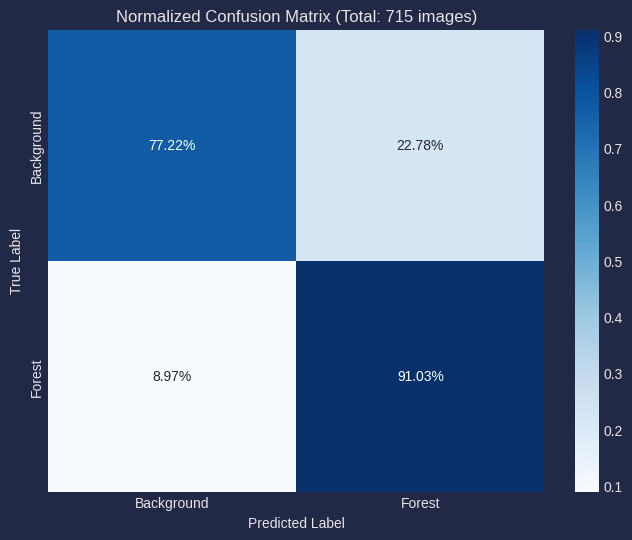

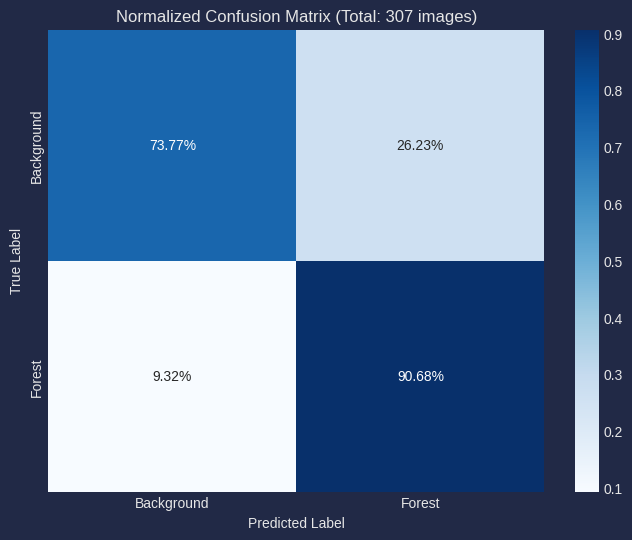

In [110]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

In [111]:
# Создаем модель
model = smp.Unet(
    encoder_name="resnet34",        # Энкодер (можно менять на resnet50, efficientnet-b0 и т.д.)
    encoder_weights="imagenet",     # Используем веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (лес / не лес)
    activation=None                 # Оставляем логиты (удобнее для функции потерь)
)

# Сразу отправляем модель на вашу видеокарту
model.to(DEVICE)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [112]:
dice_loss = smp.losses.DiceLoss(mode='binary', smooth=1.0)
bce_loss = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

# Создаем гибридную функцию (она будет вызываться внутри пайплайна)
def multi_criterion(preds, targets):
    if targets.ndim == 3:
        targets = targets.unsqueeze(1)
    return 0.5 * dice_loss(preds, targets) + 0.5 * bce_loss(preds, targets)

# Оптимизатор (уже с твоим пониженным lr и регуляризацией)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=config['learning_rate']*0.5, 
    weight_decay=0.05
)

In [113]:
history = run_train_pipeline(
    model=model,
    optimizer=optimizer,
    criterion=multi_criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_ResNet_Forest_mod_e20_CRIT_v2'
)

Epoch 1/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.06it/s, f1=0.8462, iou=0.7333, loss=0.3540]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.4588 | IoU: 0.5381 | F1: 0.6727
Valid -> Loss: 0.3921 | IoU: 0.7231 | F1: 0.8376
Metrics -> Precision: 0.8633 | Recall: 0.8168 | ROC AUC: 0.8866 | PR AUC: 0.9052
Learning Rate: 5e-05



Epoch 2/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.8152, iou=0.6881, loss=0.3502]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.3907 | IoU: 0.7103 | F1: 0.8290
Valid -> Loss: 0.3747 | IoU: 0.7159 | F1: 0.8325
Metrics -> Precision: 0.8915 | Recall: 0.7841 | ROC AUC: 0.9035 | PR AUC: 0.9237
Learning Rate: 5e-05



Epoch 3/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.08it/s, f1=0.8442, iou=0.7304, loss=0.3800]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.3736 | IoU: 0.7284 | F1: 0.8416
Valid -> Loss: 0.3722 | IoU: 0.7187 | F1: 0.8346
Metrics -> Precision: 0.8911 | Recall: 0.7885 | ROC AUC: 0.9054 | PR AUC: 0.9260
Learning Rate: 5e-05



Epoch 4/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.6072, iou=0.4360, loss=0.6152]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.3684 | IoU: 0.7498 | F1: 0.8557
Valid -> Loss: 0.3621 | IoU: 0.7607 | F1: 0.8626
Metrics -> Precision: 0.8646 | Recall: 0.8629 | ROC AUC: 0.9092 | PR AUC: 0.9272
Learning Rate: 5e-05



Epoch 5/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9006, iou=0.8192, loss=0.3089]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.3619 | IoU: 0.7623 | F1: 0.8639
Valid -> Loss: 0.3611 | IoU: 0.7613 | F1: 0.8628
Metrics -> Precision: 0.8766 | Recall: 0.8521 | ROC AUC: 0.9145 | PR AUC: 0.9321
Learning Rate: 5e-05



Epoch 6/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9250, iou=0.8605, loss=0.2788]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.3587 | IoU: 0.7679 | F1: 0.8676
Valid -> Loss: 0.3604 | IoU: 0.7427 | F1: 0.8507
Metrics -> Precision: 0.8940 | Recall: 0.8140 | ROC AUC: 0.9150 | PR AUC: 0.9354
Learning Rate: 5e-05



Epoch 7/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.8283, iou=0.7070, loss=0.4065]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.3538 | IoU: 0.7730 | F1: 0.8708
Valid -> Loss: 0.3664 | IoU: 0.7388 | F1: 0.8481
Metrics -> Precision: 0.8946 | Recall: 0.8094 | ROC AUC: 0.9157 | PR AUC: 0.9347
Learning Rate: 5e-05



Epoch 8/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9044, iou=0.8254, loss=0.2951]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.3489 | IoU: 0.7816 | F1: 0.8763
Valid -> Loss: 0.3488 | IoU: 0.7675 | F1: 0.8672
Metrics -> Precision: 0.8931 | Recall: 0.8455 | ROC AUC: 0.9234 | PR AUC: 0.9410
Learning Rate: 5e-05



Epoch 9/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9294, iou=0.8681, loss=0.2837]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.3451 | IoU: 0.7848 | F1: 0.8783
Valid -> Loss: 0.3550 | IoU: 0.7770 | F1: 0.8731
Metrics -> Precision: 0.8672 | Recall: 0.8816 | ROC AUC: 0.9187 | PR AUC: 0.9362
Learning Rate: 5e-05



Epoch 10/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.7640, iou=0.6181, loss=0.4938]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.3403 | IoU: 0.7919 | F1: 0.8828
Valid -> Loss: 0.3563 | IoU: 0.7554 | F1: 0.8589
Metrics -> Precision: 0.8842 | Recall: 0.8376 | ROC AUC: 0.9177 | PR AUC: 0.9384
Learning Rate: 5e-05



Epoch 11/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.08it/s, f1=0.9135, iou=0.8408, loss=0.2958]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.3370 | IoU: 0.7972 | F1: 0.8859
Valid -> Loss: 0.3507 | IoU: 0.7729 | F1: 0.8707
Metrics -> Precision: 0.8777 | Recall: 0.8662 | ROC AUC: 0.9215 | PR AUC: 0.9411
Learning Rate: 2.5e-05



Epoch 12/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9360, iou=0.8797, loss=0.3035]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.3259 | IoU: 0.8119 | F1: 0.8953
Valid -> Loss: 0.3525 | IoU: 0.7784 | F1: 0.8739
Metrics -> Precision: 0.8668 | Recall: 0.8835 | ROC AUC: 0.9164 | PR AUC: 0.9332
Learning Rate: 2.5e-05



Epoch 13/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.08it/s, f1=0.9590, iou=0.9212, loss=0.2345]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.3233 | IoU: 0.8148 | F1: 0.8971
Valid -> Loss: 0.3462 | IoU: 0.7765 | F1: 0.8726
Metrics -> Precision: 0.8848 | Recall: 0.8631 | ROC AUC: 0.9256 | PR AUC: 0.9445
Learning Rate: 2.5e-05



Epoch 14/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.08it/s, f1=0.8393, iou=0.7231, loss=0.3612]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.3185 | IoU: 0.8216 | F1: 0.9012
Valid -> Loss: 0.3523 | IoU: 0.7816 | F1: 0.8759
Metrics -> Precision: 0.8676 | Recall: 0.8868 | ROC AUC: 0.9207 | PR AUC: 0.9393
Learning Rate: 2.5e-05



Epoch 15/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.08it/s, f1=0.8287, iou=0.7076, loss=0.4245]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.3154 | IoU: 0.8262 | F1: 0.9040
Valid -> Loss: 0.3524 | IoU: 0.7724 | F1: 0.8700
Metrics -> Precision: 0.8809 | Recall: 0.8623 | ROC AUC: 0.9196 | PR AUC: 0.9357
Learning Rate: 2.5e-05



Epoch 16/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.8897, iou=0.8013, loss=0.3363]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.3131 | IoU: 0.8280 | F1: 0.9052
Valid -> Loss: 0.3516 | IoU: 0.7722 | F1: 0.8701
Metrics -> Precision: 0.8876 | Recall: 0.8565 | ROC AUC: 0.9229 | PR AUC: 0.9395
Learning Rate: 1.25e-05



Epoch 17/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.06it/s, f1=0.9072, iou=0.8302, loss=0.2947]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.3081 | IoU: 0.8358 | F1: 0.9098
Valid -> Loss: 0.3566 | IoU: 0.7626 | F1: 0.8635
Metrics -> Precision: 0.8882 | Recall: 0.8439 | ROC AUC: 0.9203 | PR AUC: 0.9391
Learning Rate: 1.25e-05



Epoch 18/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.8365, iou=0.7189, loss=0.3761]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.3063 | IoU: 0.8381 | F1: 0.9111
Valid -> Loss: 0.3466 | IoU: 0.7821 | F1: 0.8762
Metrics -> Precision: 0.8814 | Recall: 0.8735 | ROC AUC: 0.9241 | PR AUC: 0.9405
Learning Rate: 1.25e-05



Epoch 19/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9266, iou=0.8632, loss=0.2911]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.3043 | IoU: 0.8418 | F1: 0.9133
Valid -> Loss: 0.3500 | IoU: 0.7771 | F1: 0.8731
Metrics -> Precision: 0.8775 | Recall: 0.8716 | ROC AUC: 0.9214 | PR AUC: 0.9371
Learning Rate: 6.25e-06



Epoch 20/20 [Train]: 100%|██████████| 256/256 [00:31<00:00,  8.07it/s, f1=0.9658, iou=0.9338, loss=0.2492]
2026/02/20 02:24:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.2997 | IoU: 0.8473 | F1: 0.9167
Valid -> Loss: 0.3514 | IoU: 0.7823 | F1: 0.8763
Metrics -> Precision: 0.8687 | Recall: 0.8867 | ROC AUC: 0.9203 | PR AUC: 0.9365
Learning Rate: 6.25e-06



In [114]:
history_all['Unet_ResNet_mod_e20_crit_v2'] = history

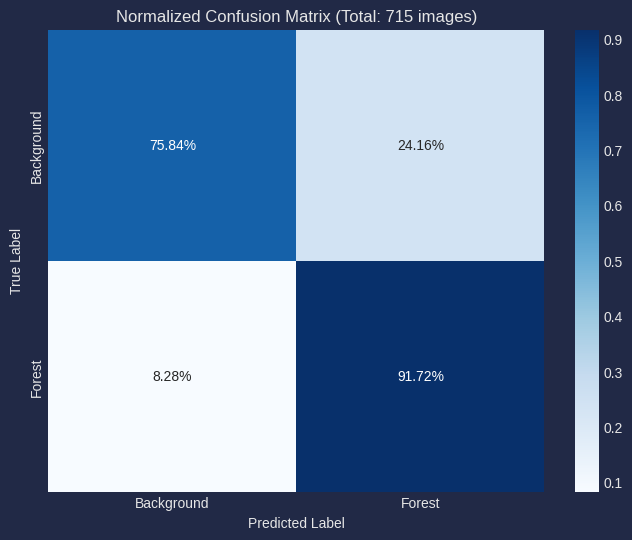

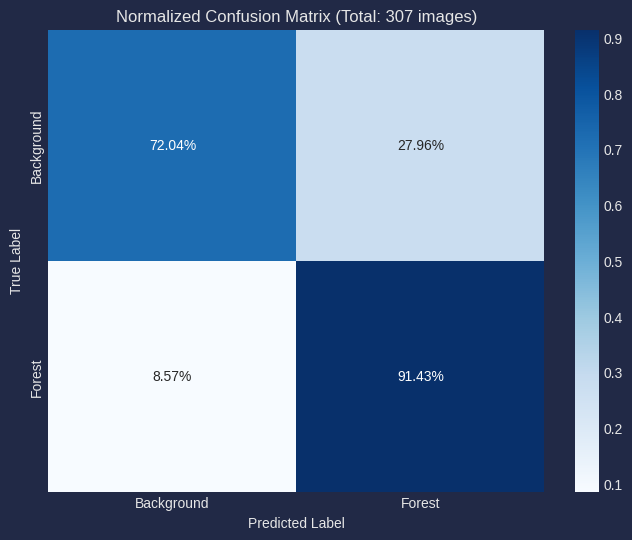

In [115]:
plot_segmentation_confusion_matrix(model, valid_loader, DEVICE)
plot_segmentation_confusion_matrix(model, test_loader, DEVICE)

Лучшие показатели IoU и более стабильный график 

In [25]:
import torch
import gc

# 1. Удаляем модель или тензоры
del model 
del optimizer

model = None

# 2. Принудительно запускаем сборщик мусора Python
gc.collect()

# 3. Теперь очищаем кэш видеокарты
torch.cuda.empty_cache()

In [26]:
# Финал

model_f = smp.Unet(
    encoder_name="efficientnet-b3", # Меняем resnet34 на efficientnet-b3
    encoder_weights="imagenet",     # Веса, предобученные на ImageNet
    in_channels=3,                  # 3 канала (RGB)
    classes=1,                      # 1 класс (объект / фон)
    activation=None,                # Без активации (для использования BCEWithLogitsLoss или DiceLoss)
    decoder_attention_type='scse' 
)
# Сразу отправляем модель на вашу видеокарту
model_f.to(DEVICE)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [30]:
config

{'batch_size': 16,
 'learning_rate': 0.0001,
 'epochs': 30,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [29]:
config['epochs'] = 30
config['learning_rate'] = 0.0001

In [31]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary', smooth=1.0)

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(
    model_f.parameters(), 
    lr=config['learning_rate'] * 0.5, # Делаем шаг поменьше
    weight_decay=0.05                 # Усиливаем регуляризацию
)

In [32]:
history = run_train_pipeline(
    model=model_f,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Unet_EfiNet_Forest_mod_e20_final'
)

2026/02/20 09:02:51 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/20 09:02:51 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/20 09:02:51 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/20 09:02:51 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/20 09:02:51 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/20 09:02:51 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/20 09:02:52 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/20 09:02:52 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Epoch 1/30 [Train]: 100%|██████████| 256/256 [01:02<00:00,  4.11it/s, f1=0.8332, iou=0.7140, loss=0.2146]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2778 | IoU: 0.6185 | F1: 0.7539
Valid -> Loss: 0.1902 | IoU: 0.7528 | F1: 0.8575
Metrics -> Precision: 0.8228 | Recall: 0.8983 | ROC AUC: 0.8724 | PR AUC: 0.8817
Learning Rate: 5e-05



Epoch 2/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.7054, iou=0.5448, loss=0.3050]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1844 | IoU: 0.7449 | F1: 0.8525
Valid -> Loss: 0.1588 | IoU: 0.7716 | F1: 0.8697
Metrics -> Precision: 0.8448 | Recall: 0.8992 | ROC AUC: 0.8845 | PR AUC: 0.8887
Learning Rate: 5e-05



Epoch 3/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, f1=0.8375, iou=0.7204, loss=0.1701]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1609 | IoU: 0.7582 | F1: 0.8611
Valid -> Loss: 0.1472 | IoU: 0.7719 | F1: 0.8699
Metrics -> Precision: 0.8422 | Recall: 0.9019 | ROC AUC: 0.8818 | PR AUC: 0.8839
Learning Rate: 5e-05



Epoch 4/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.7169, iou=0.5587, loss=0.2753]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1476 | IoU: 0.7676 | F1: 0.8668
Valid -> Loss: 0.1369 | IoU: 0.7776 | F1: 0.8736
Metrics -> Precision: 0.8477 | Recall: 0.9038 | ROC AUC: 0.8856 | PR AUC: 0.8912
Learning Rate: 5e-05



Epoch 5/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.8302, iou=0.7098, loss=0.1738]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1392 | IoU: 0.7736 | F1: 0.8711
Valid -> Loss: 0.1319 | IoU: 0.7820 | F1: 0.8763
Metrics -> Precision: 0.8373 | Recall: 0.9220 | ROC AUC: 0.8820 | PR AUC: 0.8844
Learning Rate: 5e-05



Epoch 6/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.8567, iou=0.7493, loss=0.1498]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1341 | IoU: 0.7773 | F1: 0.8732
Valid -> Loss: 0.1271 | IoU: 0.7863 | F1: 0.8791
Metrics -> Precision: 0.8470 | Recall: 0.9163 | ROC AUC: 0.8844 | PR AUC: 0.8831
Learning Rate: 5e-05



Epoch 7/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8100, iou=0.6807, loss=0.1956]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1279 | IoU: 0.7839 | F1: 0.8777
Valid -> Loss: 0.1255 | IoU: 0.7869 | F1: 0.8794
Metrics -> Precision: 0.8427 | Recall: 0.9221 | ROC AUC: 0.8823 | PR AUC: 0.8799
Learning Rate: 5e-05



Epoch 8/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.7261, iou=0.5700, loss=0.2776]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1239 | IoU: 0.7883 | F1: 0.8804
Valid -> Loss: 0.1263 | IoU: 0.7831 | F1: 0.8769
Metrics -> Precision: 0.8460 | Recall: 0.9128 | ROC AUC: 0.8830 | PR AUC: 0.8856
Learning Rate: 5e-05



Epoch 9/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8882, iou=0.7989, loss=0.1138]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1195 | IoU: 0.7935 | F1: 0.8837
Valid -> Loss: 0.1237 | IoU: 0.7864 | F1: 0.8791
Metrics -> Precision: 0.8550 | Recall: 0.9068 | ROC AUC: 0.8886 | PR AUC: 0.8905
Learning Rate: 5e-05



Epoch 10/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8595, iou=0.7536, loss=0.1406]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1174 | IoU: 0.7961 | F1: 0.8852
Valid -> Loss: 0.1225 | IoU: 0.7870 | F1: 0.8793
Metrics -> Precision: 0.8529 | Recall: 0.9099 | ROC AUC: 0.8852 | PR AUC: 0.8870
Learning Rate: 5e-05



Epoch 11/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.14it/s, f1=0.7762, iou=0.6342, loss=0.2240]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.1170 | IoU: 0.7964 | F1: 0.8853
Valid -> Loss: 0.1215 | IoU: 0.7880 | F1: 0.8803
Metrics -> Precision: 0.8475 | Recall: 0.9182 | ROC AUC: 0.8895 | PR AUC: 0.8917
Learning Rate: 5e-05



Epoch 12/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.9043, iou=0.8254, loss=0.0996]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.1097 | IoU: 0.8072 | F1: 0.8921
Valid -> Loss: 0.1250 | IoU: 0.7823 | F1: 0.8763
Metrics -> Precision: 0.8494 | Recall: 0.9074 | ROC AUC: 0.8844 | PR AUC: 0.8872
Learning Rate: 5e-05



Epoch 13/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.9077, iou=0.8310, loss=0.0934]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.1086 | IoU: 0.8084 | F1: 0.8928
Valid -> Loss: 0.1232 | IoU: 0.7844 | F1: 0.8779
Metrics -> Precision: 0.8604 | Recall: 0.8985 | ROC AUC: 0.8792 | PR AUC: 0.8714
Learning Rate: 5e-05



Epoch 14/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, f1=0.9464, iou=0.8983, loss=0.0600]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.1078 | IoU: 0.8094 | F1: 0.8935
Valid -> Loss: 0.1220 | IoU: 0.7864 | F1: 0.8791
Metrics -> Precision: 0.8449 | Recall: 0.9186 | ROC AUC: 0.8800 | PR AUC: 0.8740
Learning Rate: 2.5e-05



Epoch 15/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.9055, iou=0.8273, loss=0.0945]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.1009 | IoU: 0.8201 | F1: 0.9003
Valid -> Loss: 0.1221 | IoU: 0.7858 | F1: 0.8787
Metrics -> Precision: 0.8494 | Recall: 0.9124 | ROC AUC: 0.8834 | PR AUC: 0.8840
Learning Rate: 2.5e-05



Epoch 16/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.16it/s, f1=0.8814, iou=0.7879, loss=0.1224]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.0996 | IoU: 0.8221 | F1: 0.9015
Valid -> Loss: 0.1203 | IoU: 0.7885 | F1: 0.8804
Metrics -> Precision: 0.8521 | Recall: 0.9129 | ROC AUC: 0.8889 | PR AUC: 0.8922
Learning Rate: 2.5e-05



Epoch 17/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8486, iou=0.7371, loss=0.1515]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.0990 | IoU: 0.8228 | F1: 0.9019
Valid -> Loss: 0.1216 | IoU: 0.7858 | F1: 0.8787
Metrics -> Precision: 0.8665 | Recall: 0.8933 | ROC AUC: 0.8886 | PR AUC: 0.8995
Learning Rate: 2.5e-05



Epoch 18/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.7875, iou=0.6495, loss=0.2104]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.0983 | IoU: 0.8243 | F1: 0.9026
Valid -> Loss: 0.1199 | IoU: 0.7888 | F1: 0.8808
Metrics -> Precision: 0.8521 | Recall: 0.9135 | ROC AUC: 0.8854 | PR AUC: 0.8841
Learning Rate: 2.5e-05



Epoch 19/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.19it/s, f1=0.9362, iou=0.8800, loss=0.0637]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.0945 | IoU: 0.8302 | F1: 0.9064
Valid -> Loss: 0.1195 | IoU: 0.7893 | F1: 0.8809
Metrics -> Precision: 0.8570 | Recall: 0.9082 | ROC AUC: 0.8856 | PR AUC: 0.8858
Learning Rate: 2.5e-05



Epoch 20/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, f1=0.9546, iou=0.9132, loss=0.0456]


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.0952 | IoU: 0.8293 | F1: 0.9056
Valid -> Loss: 0.1203 | IoU: 0.7879 | F1: 0.8801
Metrics -> Precision: 0.8562 | Recall: 0.9075 | ROC AUC: 0.8876 | PR AUC: 0.8891
Learning Rate: 2.5e-05



Epoch 21/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, f1=0.9463, iou=0.8981, loss=0.0539]


Записан расширенный лог в mlflow Epoch 21

[Summary Epoch 21]
Train -> Loss: 0.0952 | IoU: 0.8293 | F1: 0.9056
Valid -> Loss: 0.1179 | IoU: 0.7919 | F1: 0.8826
Metrics -> Precision: 0.8474 | Recall: 0.9229 | ROC AUC: 0.8894 | PR AUC: 0.8896
Learning Rate: 2.5e-05



Epoch 22/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.17it/s, f1=0.8351, iou=0.7169, loss=0.1656]


Записан расширенный лог в mlflow Epoch 22

[Summary Epoch 22]
Train -> Loss: 0.0921 | IoU: 0.8337 | F1: 0.9085
Valid -> Loss: 0.1174 | IoU: 0.7926 | F1: 0.8832
Metrics -> Precision: 0.8455 | Recall: 0.9263 | ROC AUC: 0.8907 | PR AUC: 0.8937
Learning Rate: 2.5e-05



Epoch 23/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, f1=0.8842, iou=0.7924, loss=0.1166]


Записан расширенный лог в mlflow Epoch 23

[Summary Epoch 23]
Train -> Loss: 0.0921 | IoU: 0.8337 | F1: 0.9085
Valid -> Loss: 0.1175 | IoU: 0.7922 | F1: 0.8828
Metrics -> Precision: 0.8588 | Recall: 0.9102 | ROC AUC: 0.8948 | PR AUC: 0.9026
Learning Rate: 2.5e-05



Epoch 24/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.14it/s, f1=0.9180, iou=0.8485, loss=0.0827]


Записан расширенный лог в mlflow Epoch 24

[Summary Epoch 24]
Train -> Loss: 0.0905 | IoU: 0.8366 | F1: 0.9101
Valid -> Loss: 0.1197 | IoU: 0.7888 | F1: 0.8805
Metrics -> Precision: 0.8604 | Recall: 0.9038 | ROC AUC: 0.8939 | PR AUC: 0.9026
Learning Rate: 2.5e-05



Epoch 25/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.14it/s, f1=0.8556, iou=0.7477, loss=0.1443]


Записан расширенный лог в mlflow Epoch 25

[Summary Epoch 25]
Train -> Loss: 0.0903 | IoU: 0.8366 | F1: 0.9102
Valid -> Loss: 0.1175 | IoU: 0.7921 | F1: 0.8827
Metrics -> Precision: 0.8637 | Recall: 0.9043 | ROC AUC: 0.8924 | PR AUC: 0.8924
Learning Rate: 1.25e-05



Epoch 26/30 [Train]: 100%|██████████| 256/256 [01:02<00:00,  4.13it/s, f1=0.8665, iou=0.7644, loss=0.1343]


Записан расширенный лог в mlflow Epoch 26

[Summary Epoch 26]
Train -> Loss: 0.0874 | IoU: 0.8414 | F1: 0.9131
Valid -> Loss: 0.1183 | IoU: 0.7910 | F1: 0.8819
Metrics -> Precision: 0.8582 | Recall: 0.9088 | ROC AUC: 0.8921 | PR AUC: 0.8925
Learning Rate: 1.25e-05



Epoch 27/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.13it/s, f1=0.9399, iou=0.8866, loss=0.0607]


Записан расширенный лог в mlflow Epoch 27

[Summary Epoch 27]
Train -> Loss: 0.0885 | IoU: 0.8395 | F1: 0.9119
Valid -> Loss: 0.1170 | IoU: 0.7930 | F1: 0.8833
Metrics -> Precision: 0.8503 | Recall: 0.9208 | ROC AUC: 0.8834 | PR AUC: 0.8754
Learning Rate: 1.25e-05



Epoch 28/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.15it/s, f1=0.8978, iou=0.8146, loss=0.1033]


Записан расширенный лог в mlflow Epoch 28

[Summary Epoch 28]
Train -> Loss: 0.0857 | IoU: 0.8442 | F1: 0.9147
Valid -> Loss: 0.1165 | IoU: 0.7940 | F1: 0.8837
Metrics -> Precision: 0.8603 | Recall: 0.9104 | ROC AUC: 0.8918 | PR AUC: 0.8883
Learning Rate: 1.25e-05



Epoch 29/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.14it/s, f1=0.9471, iou=0.8996, loss=0.0527]


Записан расширенный лог в mlflow Epoch 29

[Summary Epoch 29]
Train -> Loss: 0.0854 | IoU: 0.8449 | F1: 0.9151
Valid -> Loss: 0.1185 | IoU: 0.7905 | F1: 0.8816
Metrics -> Precision: 0.8598 | Recall: 0.9065 | ROC AUC: 0.8910 | PR AUC: 0.8948
Learning Rate: 1.25e-05



Epoch 30/30 [Train]: 100%|██████████| 256/256 [01:01<00:00,  4.14it/s, f1=0.9209, iou=0.8534, loss=0.0790]


Записан расширенный лог в mlflow Epoch 30

[Summary Epoch 30]
Train -> Loss: 0.0854 | IoU: 0.8446 | F1: 0.9150
Valid -> Loss: 0.1173 | IoU: 0.7924 | F1: 0.8829
Metrics -> Precision: 0.8528 | Recall: 0.9172 | ROC AUC: 0.8854 | PR AUC: 0.8806
Learning Rate: 1.25e-05



2026/02/20 09:44:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


In [34]:
history_all = {}
history_all['Unet_EfiNet_mod_e20_final'] = history

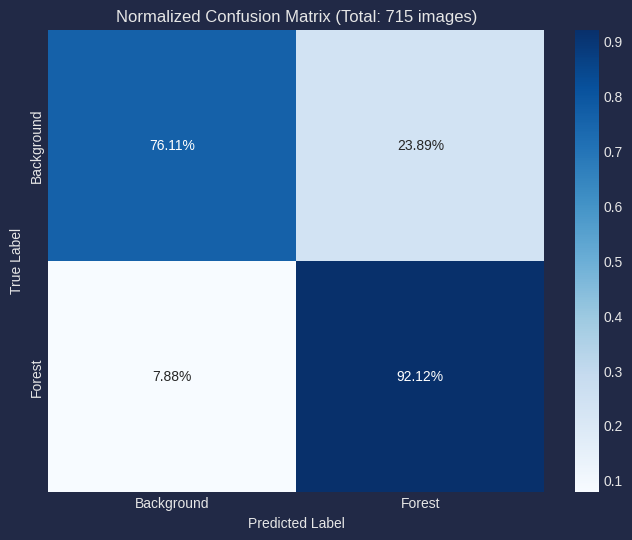

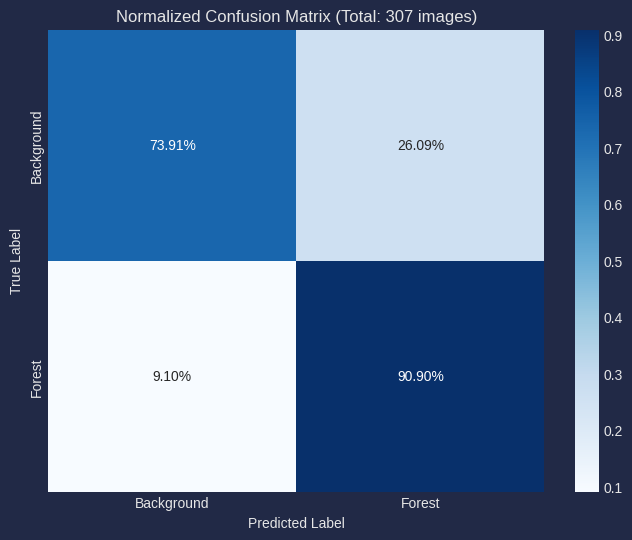

In [35]:
plot_segmentation_confusion_matrix(model_f, valid_loader, DEVICE)
plot_segmentation_confusion_matrix(model_f, test_loader, DEVICE)

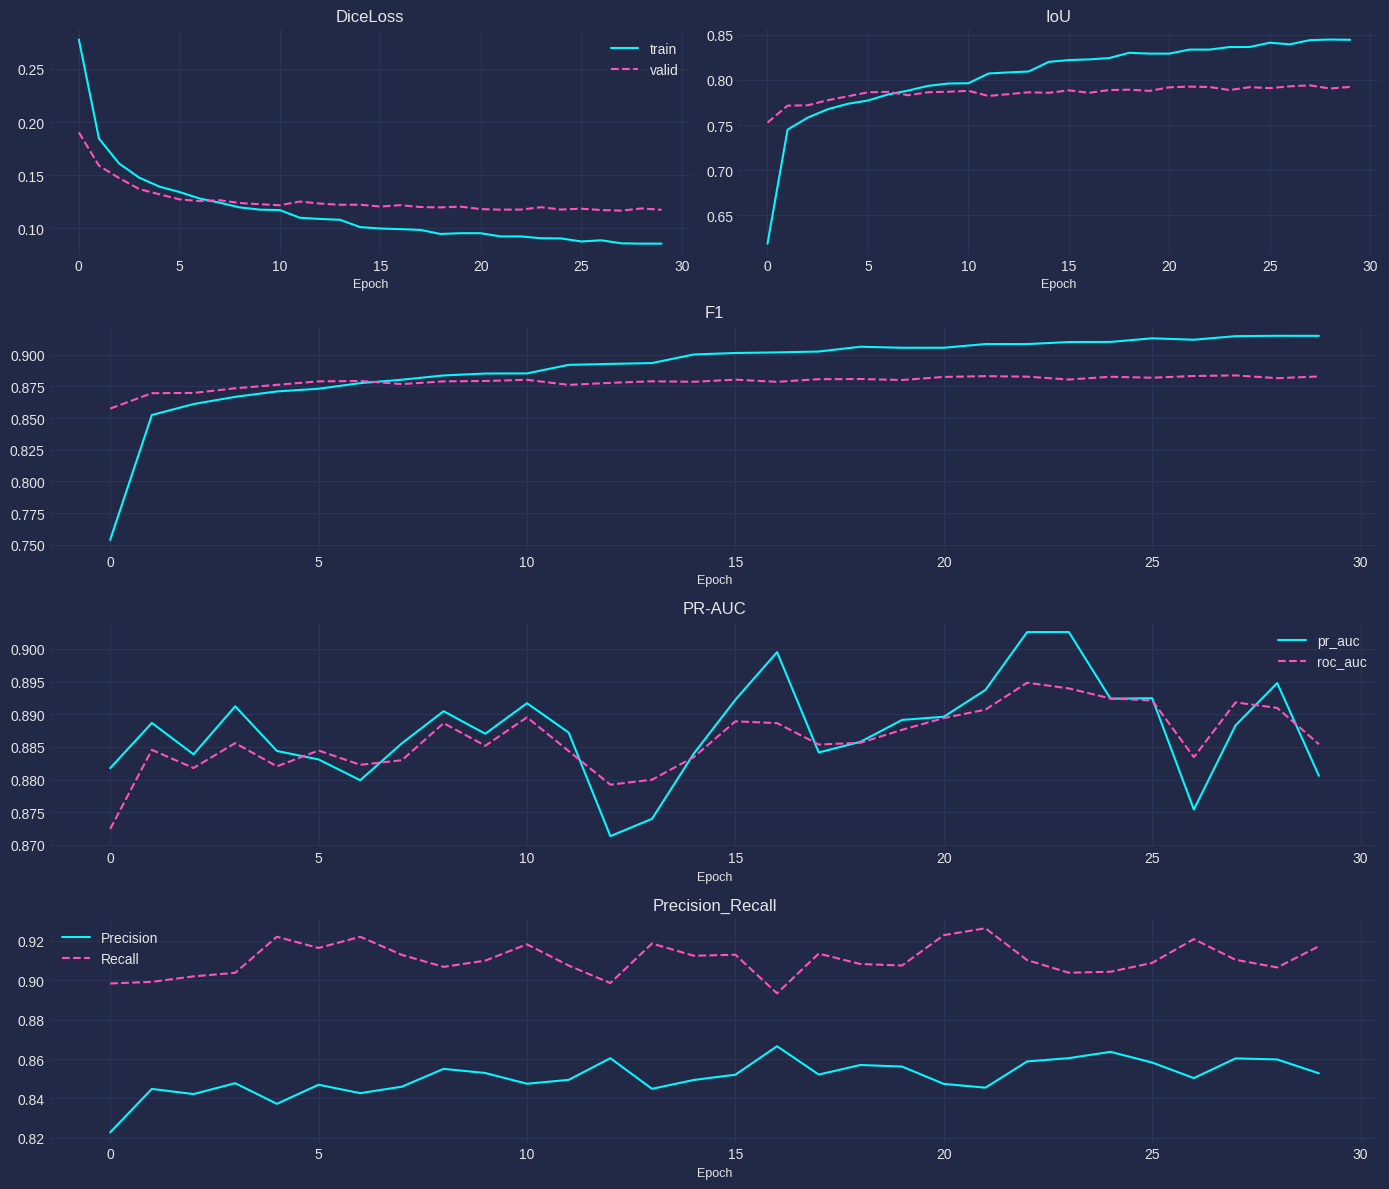

In [136]:
plot_logs(history_all['Unet_EfiNet_mod_e20_final'])

/tmp/ipykernel_2012582/875037328.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


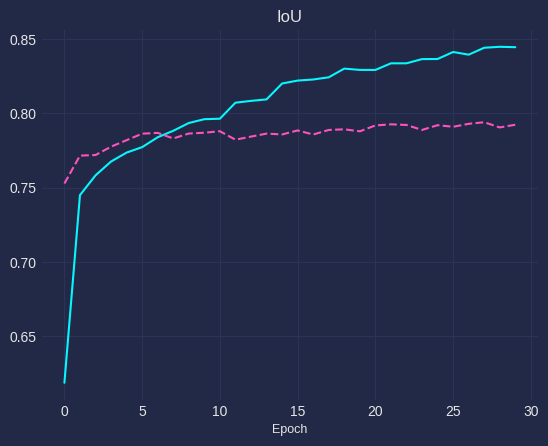

In [138]:
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['train_iou'])
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['valid_iou'], linestyle='--')
plt.xlabel('Epoch', fontsize=9)
plt.title(f'IoU')
plt.legend()
plt.show()

/tmp/ipykernel_2012582/1145670367.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


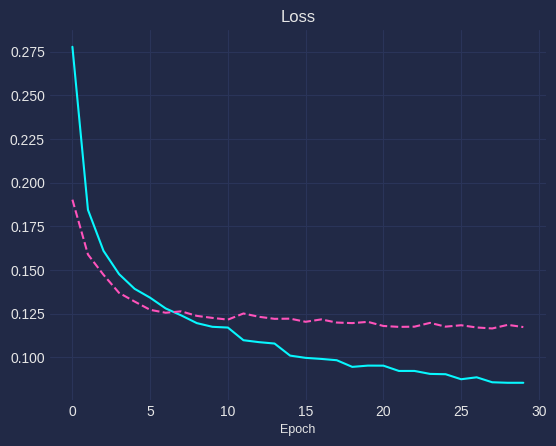

In [139]:
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['train_loss'])
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['valid_loss'], linestyle='--')
plt.xlabel('Epoch', fontsize=9)
plt.title(f'Loss')
plt.legend()
plt.show()

/tmp/ipykernel_2012582/785778386.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


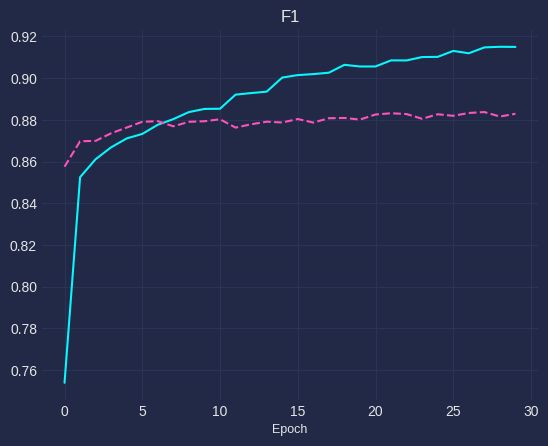

In [141]:
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['train_f1'])
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['valid_f1'], linestyle='--')
plt.xlabel('Epoch', fontsize=9)
plt.title(f'F1')
plt.legend()
plt.show()

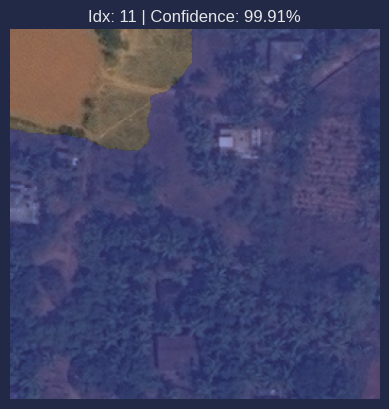

In [103]:
def show_pred(model, dataset, confidence=0.5):
    idx = random.randint(0, len(dataset)-1)
    img_t, mask_t = dataset[idx]
    
    model.eval()
    with torch.no_grad():
        # 1. Получаем вероятности (0.0 - 1.0)
        probs = model(img_t.unsqueeze(0).to(DEVICE)).sigmoid().cpu().squeeze()
        
        # 2. Создаем бинарную маску по порогу
        pred = (probs > confidence).numpy()
        
        # 3. Считаем среднюю уверенность только для предсказанных пикселей (где есть дерево)
        if pred.sum() > 0:
            mean_conf = probs[probs > confidence].mean().item()
        else:
            mean_conf = 0.0

    # Скрываем фон
    pred_masked = np.ma.masked_where(pred == 0, pred)
    img_vis = (img_t.permute(1, 2, 0) * 0.225 + 0.456).clamp(0, 1).cpu()

    plt.imshow(img_vis)
    plt.imshow(pred_masked, alpha=0.5, cmap='terrain') 
    
    # Добавляем уверенность в заголовок
    plt.title(f"Idx: {idx} | Confidence: {mean_conf:.2%}")
    plt.axis('off')
    plt.show()

show_pred(model_f, test_dataset, confidence=0.7)

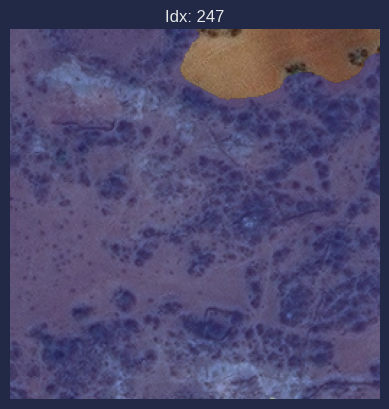

In [51]:
def show_pred(model, dataset, confidence=0.5):
    idx = random.randint(0, len(dataset)-1)
    img_t, mask_t = dataset[idx]
    
    model.eval()
    with torch.no_grad():
        pred = model(img_t.unsqueeze(0).to(DEVICE))
        pred = (pred.sigmoid() > confidence).cpu().squeeze().numpy() # в numpy

    # СКРЫВАЕМ ФОН: говорим не рисовать там, где pred == 0
    pred_masked = np.ma.masked_where(pred == 0, pred)

    img_vis = (img_t.permute(1, 2, 0) * 0.225 + 0.456).clamp(0, 1).cpu()

    plt.imshow(img_vis)
    # Рисуем только замаскированную часть
    plt.imshow(pred_masked, alpha=0.5, cmap='terrain') 
    plt.title(f"Idx: {idx}")
    plt.axis('off')
    plt.show()

# Вызов:
show_pred(model_f, test_dataset, confidence=0.7)

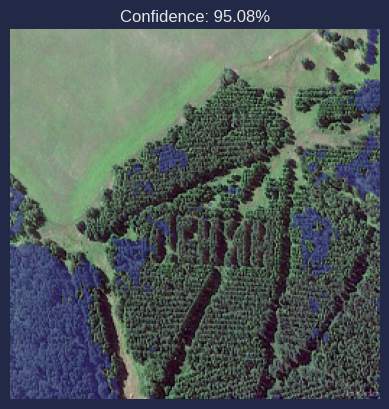

In [131]:
import requests, io
from PIL import Image

def predict_url(model, url, conf=0.7):
    # Загрузка
    resp = requests.get(url)
    img = np.array(Image.open(io.BytesIO(resp.content)).convert("RGB"))
    
    # Трансформ и инференс
    img_t = valid_transform(image=img)["image"].to(DEVICE)
    model.eval()
    with torch.no_grad():
        probs = model(img_t.unsqueeze(0)).sigmoid().cpu().squeeze().numpy()
    
    # Маска и уверенность
    mask = (probs > conf)
    mean_c = probs[mask].mean() if mask.any() else 0

    # Визуализация (денормализация через mean/std из вашего кода)
    vis = (img_t.permute(1, 2, 0).cpu().numpy() * std + mean).clip(0, 1)
    
    plt.imshow(vis)
    plt.imshow(np.ma.masked_where(~mask, mask), alpha=0.5, cmap='terrain')
    plt.title(f"Confidence: {mean_c:.2%}")
    plt.axis('off')
    plt.show()

url = r"https://uraloved.ru/images/mesta/kosmos/ural-iz-kosmosa-53.jpg"

predict_url(model_f, url, conf=0.7)

https://lesregion.ru/uploads/posts/2020-10/1601888474_unnamed-1.jpg

https://mapsshop.ru/data/pictures_tpl/SPUTNIK_karta_rajona_20m/380/33.jpg

https://orenburg.rcfh.ru/upload/iblock/841/zlhhg73yckko69gbrijjs286enw23hge/11.jpg

https://uraloved.ru/images/mesta/kosmos/ural-iz-kosmosa-53.jpg

https://mapsshop.ru/data/pictures_tpl/SPUTNIK_karta_goroda_20m/380/24.jpg

https://mapsshop.ru/data/pictures_tpl/SPUTNIK_karta_goroda_20m/26.jpg

https://mapsshop.ru/data/pictures_tpl/SPUTNIK_karta_oblasci_250m/4.jpg

https://novate.ru/files/u41093/nadpisi-v-sssr10.jpg


https://suzungazeta.ru/wp-content/uploads/2021/07/a056facf-ac8eeee874445a82c5573c22a819aa91.jpeg

https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRCzDa4M2OzGfJWpuyxyObyHy1IYNrrtzFeEA&s

https://mapsshop.ru/data/pictures_tpl/SPUTNIK_karta_rajona_20m/380/33.jpg


In [ ]:
path_2_save_model = r"../models"

torch.save(model_f.state_dict(), os.path.join(path_2_save_model,'model_unet_dan_weights_final.pt'))
torch.save(model_f, os.path.join(path_2_save_model,'model_unet_dan_final.pt'))

In [132]:
config

{'batch_size': 16,
 'learning_rate': 0.0001,
 'epochs': 30,
 'use_mlflow': True,
 'device': 'cuda',
 'data_dir': 'data/',
 'experiment_name': 'Forest_Unet_project',
 'log_dir': 'runs/experiment1'}

In [142]:
model_f = smp.MAnet(
    encoder_name="efficientnet-b3",        # Выбор энкодера (например, resnet, efficientnet)
    encoder_weights="imagenet",     # Использование предобученных весов ImageNet
    in_channels=3,                  # Количество входных каналов (3 для RGB)
    classes=1,                      # Количество классов на выходе (например, для бинарной маски)
    activation=None                 # Тип активации (None возвращает logits)
)
# Сразу отправляем модель на вашу видеокарту
model_f.to(DEVICE)

MAnet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadd

In [143]:
# Функция потерь (комбо Dice + BCE часто работает лучше всего)
criterion = smp.losses.DiceLoss(mode='binary', smooth=1.0)

# Оптимизатор (Adam — классика для начала)
optimizer = torch.optim.AdamW(
    model_f.parameters(), 
    lr=config['learning_rate'] * 0.5, # Делаем шаг поменьше
    weight_decay=0.05                 # Усиливаем регуляризацию
)

In [144]:
history = run_train_pipeline(
    model=model_f,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader_modif,
    valid_loader=valid_loader,
    config=config,
    device=DEVICE,
    run_name='Manet_EfiNet_Forest_mod_e30_final'
)

Epoch 1/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.8906, iou=0.8028, loss=0.1669]


Записан расширенный лог в mlflow Epoch 1

[Summary Epoch 1]
Train -> Loss: 0.2942 | IoU: 0.5673 | F1: 0.7102
Valid -> Loss: 0.1926 | IoU: 0.7467 | F1: 0.8537
Metrics -> Precision: 0.8112 | Recall: 0.9040 | ROC AUC: 0.8638 | PR AUC: 0.8700
Learning Rate: 5e-05



Epoch 2/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.7798, iou=0.6391, loss=0.2421]


Записан расширенный лог в mlflow Epoch 2

[Summary Epoch 2]
Train -> Loss: 0.1843 | IoU: 0.7439 | F1: 0.8517
Valid -> Loss: 0.1639 | IoU: 0.7657 | F1: 0.8661
Metrics -> Precision: 0.8340 | Recall: 0.9031 | ROC AUC: 0.8784 | PR AUC: 0.8839
Learning Rate: 5e-05



Epoch 3/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.8725, iou=0.7738, loss=0.1536]


Записан расширенный лог в mlflow Epoch 3

[Summary Epoch 3]
Train -> Loss: 0.1616 | IoU: 0.7600 | F1: 0.8623
Valid -> Loss: 0.1489 | IoU: 0.7744 | F1: 0.8716
Metrics -> Precision: 0.8497 | Recall: 0.8971 | ROC AUC: 0.8849 | PR AUC: 0.8922
Learning Rate: 5e-05



Epoch 4/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.8792, iou=0.7845, loss=0.1308]


Записан расширенный лог в mlflow Epoch 4

[Summary Epoch 4]
Train -> Loss: 0.1519 | IoU: 0.7632 | F1: 0.8643
Valid -> Loss: 0.1434 | IoU: 0.7720 | F1: 0.8699
Metrics -> Precision: 0.8638 | Recall: 0.8787 | ROC AUC: 0.8902 | PR AUC: 0.8971
Learning Rate: 5e-05



Epoch 5/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.67it/s, f1=0.8616, iou=0.7569, loss=0.1477]


Записан расширенный лог в mlflow Epoch 5

[Summary Epoch 5]
Train -> Loss: 0.1422 | IoU: 0.7720 | F1: 0.8702
Valid -> Loss: 0.1358 | IoU: 0.7778 | F1: 0.8737
Metrics -> Precision: 0.8548 | Recall: 0.8956 | ROC AUC: 0.8852 | PR AUC: 0.8919
Learning Rate: 5e-05



Epoch 6/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.5755, iou=0.4040, loss=0.4301]


Записан расширенный лог в mlflow Epoch 6

[Summary Epoch 6]
Train -> Loss: 0.1355 | IoU: 0.7782 | F1: 0.8736
Valid -> Loss: 0.1310 | IoU: 0.7815 | F1: 0.8760
Metrics -> Precision: 0.8500 | Recall: 0.9058 | ROC AUC: 0.8809 | PR AUC: 0.8845
Learning Rate: 5e-05



Epoch 7/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.9428, iou=0.8919, loss=0.0673]


Записан расширенный лог в mlflow Epoch 7

[Summary Epoch 7]
Train -> Loss: 0.1296 | IoU: 0.7835 | F1: 0.8773
Valid -> Loss: 0.1269 | IoU: 0.7861 | F1: 0.8791
Metrics -> Precision: 0.8512 | Recall: 0.9113 | ROC AUC: 0.8854 | PR AUC: 0.8887
Learning Rate: 5e-05



Epoch 8/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s, f1=0.8232, iou=0.6995, loss=0.1822]


Записан расширенный лог в mlflow Epoch 8

[Summary Epoch 8]
Train -> Loss: 0.1280 | IoU: 0.7846 | F1: 0.8779
Valid -> Loss: 0.1262 | IoU: 0.7862 | F1: 0.8790
Metrics -> Precision: 0.8473 | Recall: 0.9155 | ROC AUC: 0.8852 | PR AUC: 0.8868
Learning Rate: 5e-05



Epoch 9/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s, f1=0.7460, iou=0.5949, loss=0.2566]


Записан расширенный лог в mlflow Epoch 9

[Summary Epoch 9]
Train -> Loss: 0.1252 | IoU: 0.7874 | F1: 0.8796
Valid -> Loss: 0.1237 | IoU: 0.7879 | F1: 0.8802
Metrics -> Precision: 0.8467 | Recall: 0.9190 | ROC AUC: 0.8835 | PR AUC: 0.8836
Learning Rate: 5e-05



Epoch 10/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.9337, iou=0.8756, loss=0.0709]


Записан расширенный лог в mlflow Epoch 10

[Summary Epoch 10]
Train -> Loss: 0.1206 | IoU: 0.7931 | F1: 0.8833
Valid -> Loss: 0.1243 | IoU: 0.7866 | F1: 0.8792
Metrics -> Precision: 0.8469 | Recall: 0.9160 | ROC AUC: 0.8824 | PR AUC: 0.8839
Learning Rate: 5e-05



Epoch 11/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s, f1=0.7668, iou=0.6217, loss=0.2347]


Записан расширенный лог в mlflow Epoch 11

[Summary Epoch 11]
Train -> Loss: 0.1198 | IoU: 0.7933 | F1: 0.8835
Valid -> Loss: 0.1203 | IoU: 0.7912 | F1: 0.8822
Metrics -> Precision: 0.8498 | Recall: 0.9192 | ROC AUC: 0.8816 | PR AUC: 0.8817
Learning Rate: 5e-05



Epoch 12/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.8398, iou=0.7238, loss=0.1613]


Записан расширенный лог в mlflow Epoch 12

[Summary Epoch 12]
Train -> Loss: 0.1138 | IoU: 0.8019 | F1: 0.8888
Valid -> Loss: 0.1237 | IoU: 0.7853 | F1: 0.8782
Metrics -> Precision: 0.8494 | Recall: 0.9113 | ROC AUC: 0.8796 | PR AUC: 0.8817
Learning Rate: 5e-05



Epoch 13/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.71it/s, f1=0.8348, iou=0.7164, loss=0.1670]


Записан расширенный лог в mlflow Epoch 13

[Summary Epoch 13]
Train -> Loss: 0.1119 | IoU: 0.8048 | F1: 0.8905
Valid -> Loss: 0.1220 | IoU: 0.7872 | F1: 0.8795
Metrics -> Precision: 0.8435 | Recall: 0.9208 | ROC AUC: 0.8805 | PR AUC: 0.8820
Learning Rate: 5e-05



Epoch 14/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.9304, iou=0.8698, loss=0.0720]


Записан расширенный лог в mlflow Epoch 14

[Summary Epoch 14]
Train -> Loss: 0.1085 | IoU: 0.8091 | F1: 0.8934
Valid -> Loss: 0.1224 | IoU: 0.7859 | F1: 0.8788
Metrics -> Precision: 0.8610 | Recall: 0.8994 | ROC AUC: 0.8802 | PR AUC: 0.8838
Learning Rate: 2.5e-05



Epoch 15/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.71it/s, f1=0.9274, iou=0.8646, loss=0.0760]


Записан расширенный лог в mlflow Epoch 15

[Summary Epoch 15]
Train -> Loss: 0.1060 | IoU: 0.8131 | F1: 0.8958
Valid -> Loss: 0.1209 | IoU: 0.7882 | F1: 0.8803
Metrics -> Precision: 0.8577 | Recall: 0.9063 | ROC AUC: 0.8843 | PR AUC: 0.8866
Learning Rate: 2.5e-05



Epoch 16/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.8734, iou=0.7753, loss=0.1282]


Записан расширенный лог в mlflow Epoch 16

[Summary Epoch 16]
Train -> Loss: 0.1035 | IoU: 0.8166 | F1: 0.8981
Valid -> Loss: 0.1188 | IoU: 0.7914 | F1: 0.8823
Metrics -> Precision: 0.8511 | Recall: 0.9180 | ROC AUC: 0.8806 | PR AUC: 0.8792
Learning Rate: 2.5e-05



Epoch 17/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.9085, iou=0.8323, loss=0.0923]


Записан расширенный лог в mlflow Epoch 17

[Summary Epoch 17]
Train -> Loss: 0.1026 | IoU: 0.8181 | F1: 0.8989
Valid -> Loss: 0.1215 | IoU: 0.7875 | F1: 0.8795
Metrics -> Precision: 0.8592 | Recall: 0.9031 | ROC AUC: 0.8840 | PR AUC: 0.8854
Learning Rate: 2.5e-05



Epoch 18/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.9634, iou=0.9294, loss=0.0404]


Записан расширенный лог в mlflow Epoch 18

[Summary Epoch 18]
Train -> Loss: 0.1003 | IoU: 0.8218 | F1: 0.9011
Valid -> Loss: 0.1204 | IoU: 0.7893 | F1: 0.8808
Metrics -> Precision: 0.8518 | Recall: 0.9142 | ROC AUC: 0.8796 | PR AUC: 0.8772
Learning Rate: 2.5e-05



Epoch 19/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s, f1=0.9101, iou=0.8350, loss=0.0898]


Записан расширенный лог в mlflow Epoch 19

[Summary Epoch 19]
Train -> Loss: 0.0985 | IoU: 0.8242 | F1: 0.9027
Valid -> Loss: 0.1216 | IoU: 0.7867 | F1: 0.8791
Metrics -> Precision: 0.8560 | Recall: 0.9056 | ROC AUC: 0.8783 | PR AUC: 0.8817
Learning Rate: 1.25e-05



Epoch 20/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.8398, iou=0.7239, loss=0.1610]


Записан расширенный лог в mlflow Epoch 20

[Summary Epoch 20]
Train -> Loss: 0.0991 | IoU: 0.8235 | F1: 0.9021
Valid -> Loss: 0.1183 | IoU: 0.7920 | F1: 0.8826
Metrics -> Precision: 0.8517 | Recall: 0.9180 | ROC AUC: 0.8850 | PR AUC: 0.8855
Learning Rate: 1.25e-05



Epoch 21/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.9132, iou=0.8403, loss=0.0875]


Записан расширенный лог в mlflow Epoch 21

[Summary Epoch 21]
Train -> Loss: 0.0965 | IoU: 0.8276 | F1: 0.9046
Valid -> Loss: 0.1191 | IoU: 0.7906 | F1: 0.8815
Metrics -> Precision: 0.8556 | Recall: 0.9115 | ROC AUC: 0.8812 | PR AUC: 0.8823
Learning Rate: 1.25e-05



Epoch 22/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s, f1=0.9284, iou=0.8664, loss=0.0734]


Записан расширенный лог в mlflow Epoch 22

[Summary Epoch 22]
Train -> Loss: 0.0948 | IoU: 0.8299 | F1: 0.9062
Valid -> Loss: 0.1222 | IoU: 0.7857 | F1: 0.8783
Metrics -> Precision: 0.8592 | Recall: 0.9006 | ROC AUC: 0.8787 | PR AUC: 0.8840
Learning Rate: 1.25e-05



Epoch 23/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.8341, iou=0.7154, loss=0.1662]


Записан расширенный лог в mlflow Epoch 23

[Summary Epoch 23]
Train -> Loss: 0.0954 | IoU: 0.8289 | F1: 0.9056
Valid -> Loss: 0.1229 | IoU: 0.7846 | F1: 0.8776
Metrics -> Precision: 0.8631 | Recall: 0.8950 | ROC AUC: 0.8791 | PR AUC: 0.8855
Learning Rate: 6.25e-06



Epoch 24/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.8224, iou=0.6984, loss=0.1782]


Записан расширенный лог в mlflow Epoch 24

[Summary Epoch 24]
Train -> Loss: 0.0960 | IoU: 0.8278 | F1: 0.9049
Valid -> Loss: 0.1193 | IoU: 0.7905 | F1: 0.8814
Metrics -> Precision: 0.8531 | Recall: 0.9141 | ROC AUC: 0.8848 | PR AUC: 0.8852
Learning Rate: 6.25e-06



Epoch 25/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.7976, iou=0.6634, loss=0.2020]


Записан расширенный лог в mlflow Epoch 25

[Summary Epoch 25]
Train -> Loss: 0.0938 | IoU: 0.8318 | F1: 0.9071
Valid -> Loss: 0.1213 | IoU: 0.7873 | F1: 0.8794
Metrics -> Precision: 0.8573 | Recall: 0.9049 | ROC AUC: 0.8824 | PR AUC: 0.8832
Learning Rate: 6.25e-06



Epoch 26/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.69it/s, f1=0.9253, iou=0.8610, loss=0.0754]


Записан расширенный лог в mlflow Epoch 26

[Summary Epoch 26]
Train -> Loss: 0.0936 | IoU: 0.8318 | F1: 0.9073
Valid -> Loss: 0.1194 | IoU: 0.7899 | F1: 0.8811
Metrics -> Precision: 0.8585 | Recall: 0.9073 | ROC AUC: 0.8794 | PR AUC: 0.8817
Learning Rate: 3.125e-06



Epoch 27/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.8763, iou=0.7799, loss=0.1238]


Записан расширенный лог в mlflow Epoch 27

[Summary Epoch 27]
Train -> Loss: 0.0937 | IoU: 0.8316 | F1: 0.9071
Valid -> Loss: 0.1192 | IoU: 0.7904 | F1: 0.8814
Metrics -> Precision: 0.8577 | Recall: 0.9089 | ROC AUC: 0.8842 | PR AUC: 0.8847
Learning Rate: 3.125e-06



Epoch 28/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.70it/s, f1=0.7809, iou=0.6406, loss=0.2203]


Записан расширенный лог в mlflow Epoch 28

[Summary Epoch 28]
Train -> Loss: 0.0937 | IoU: 0.8316 | F1: 0.9071
Valid -> Loss: 0.1192 | IoU: 0.7903 | F1: 0.8813
Metrics -> Precision: 0.8588 | Recall: 0.9074 | ROC AUC: 0.8824 | PR AUC: 0.8836
Learning Rate: 3.125e-06



Epoch 29/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.9480, iou=0.9012, loss=0.0533]


Записан расширенный лог в mlflow Epoch 29

[Summary Epoch 29]
Train -> Loss: 0.0908 | IoU: 0.8363 | F1: 0.9100
Valid -> Loss: 0.1192 | IoU: 0.7904 | F1: 0.8814
Metrics -> Precision: 0.8517 | Recall: 0.9157 | ROC AUC: 0.8802 | PR AUC: 0.8807
Learning Rate: 1.5625e-06



Epoch 30/30 [Train]: 100%|██████████| 256/256 [00:54<00:00,  4.68it/s, f1=0.9338, iou=0.8758, loss=0.0681]
2026/02/20 12:30:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


Записан расширенный лог в mlflow Epoch 30

[Summary Epoch 30]
Train -> Loss: 0.0923 | IoU: 0.8339 | F1: 0.9085
Valid -> Loss: 0.1195 | IoU: 0.7903 | F1: 0.8814
Metrics -> Precision: 0.8537 | Recall: 0.9134 | ROC AUC: 0.8853 | PR AUC: 0.8849
Learning Rate: 1.5625e-06



In [145]:
history_all['Manet_EfiNet_mod_e30_final'] = history

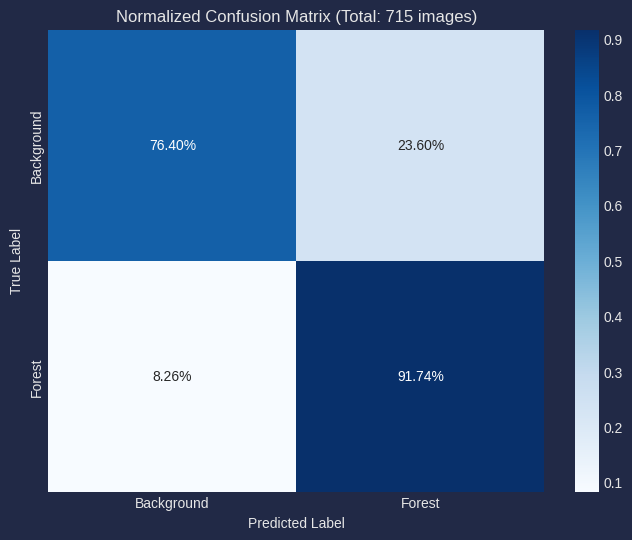

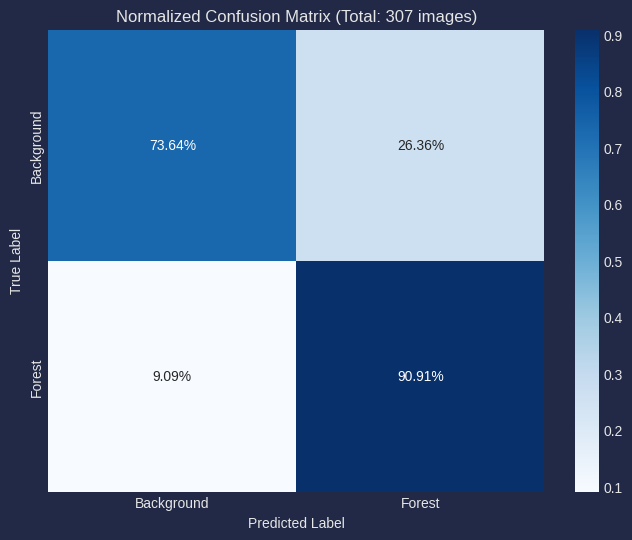

In [146]:
plot_segmentation_confusion_matrix(model_f, valid_loader, DEVICE)
plot_segmentation_confusion_matrix(model_f, test_loader, DEVICE)

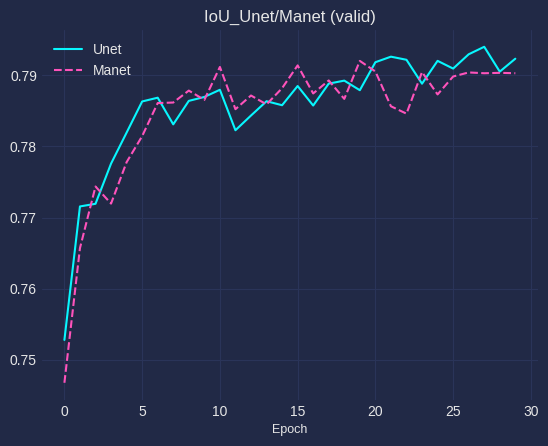

In [153]:
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['valid_iou'], label='Unet')
plt.plot(history_all['Manet_EfiNet_mod_e30_final']['valid_iou'], linestyle='--', label='Manet')
plt.xlabel('Epoch', fontsize=9)
plt.title(f'IoU_Unet/Manet (valid)')
plt.legend()
plt.show()

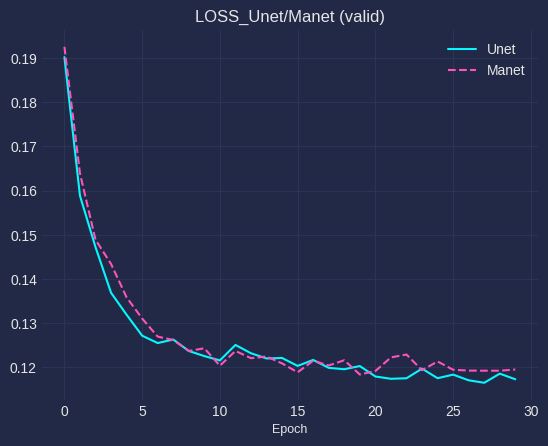

In [161]:
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['valid_loss'], label='Unet')
plt.plot(history_all['Manet_EfiNet_mod_e30_final']['valid_loss'], linestyle='--', label='Manet')
plt.xlabel('Epoch', fontsize=9)
plt.title(f'LOSS_Unet/Manet (valid)')
plt.legend()
plt.show()

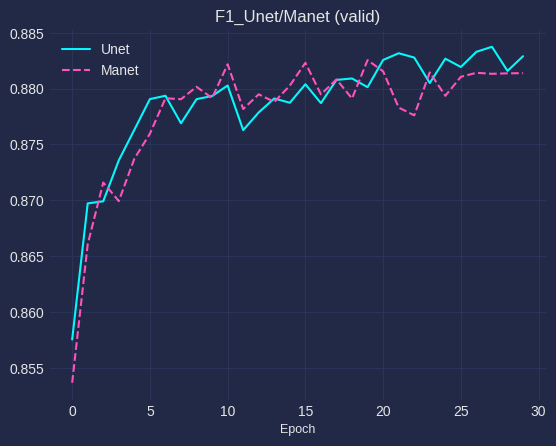

In [162]:
plt.plot(history_all['Unet_EfiNet_mod_e20_final']['valid_f1'], label='Unet')
plt.plot(history_all['Manet_EfiNet_mod_e30_final']['valid_f1'], linestyle='--', label='Manet')
plt.xlabel('Epoch', fontsize=9)
plt.title(f'F1_Unet/Manet (valid)')
plt.legend()
plt.show()

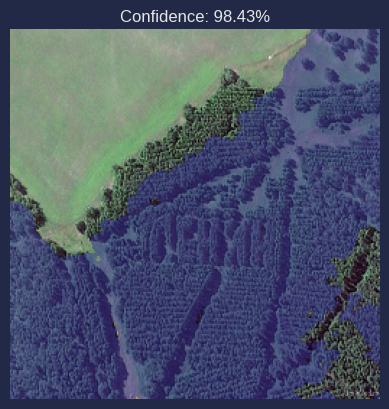

In [163]:
import requests, io
from PIL import Image

def predict_url(model, url, conf=0.7):
    # Загрузка
    resp = requests.get(url)
    img = np.array(Image.open(io.BytesIO(resp.content)).convert("RGB"))
    
    # Трансформ и инференс
    img_t = valid_transform(image=img)["image"].to(DEVICE)
    model.eval()
    with torch.no_grad():
        probs = model(img_t.unsqueeze(0)).sigmoid().cpu().squeeze().numpy()
    
    # Маска и уверенность
    mask = (probs > conf)
    mean_c = probs[mask].mean() if mask.any() else 0

    # Визуализация (денормализация через mean/std из вашего кода)
    vis = (img_t.permute(1, 2, 0).cpu().numpy() * std + mean).clip(0, 1)
    
    plt.imshow(vis)
    plt.imshow(np.ma.masked_where(~mask, mask), alpha=0.5, cmap='terrain')
    plt.title(f"Confidence: {mean_c:.2%}")
    plt.axis('off')
    plt.show()

url = r"https://uraloved.ru/images/mesta/kosmos/ural-iz-kosmosa-53.jpg"

predict_url(model_f, url, conf=0.7)

In [165]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

model_f.eval()

test_loss = []
test_iou = []
test_f1 = []
test_precision = []
test_recall = []
all_probs = []
all_targets = []

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        outputs = model_f(images)
        loss = criterion(outputs, masks)
        
        # Сбор данных для AUC (как в вашем примере)
        # ВАЖНО: .flatten() на больших данных может съесть много RAM. 
        # Если данных очень много, лучше считать AUC по эпохе иначе.
        probs = torch.sigmoid(outputs).cpu().numpy().flatten()
        targets = masks.cpu().numpy().flatten()
        all_probs.append(probs)
        all_targets.append(targets)

        # Статистика SMP
        tp, fp, fn, tn = smp.metrics.get_stats(
            output=outputs, target=masks.long(), mode='binary', threshold=0.5
        )

        # Метрики
        test_loss.append(loss.item())
        test_iou.append(smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item())
        test_f1.append(smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item())
        test_precision.append(smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item())
        test_recall.append(smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item())

# Агрегация результатов
all_probs = np.concatenate(all_probs)
all_targets = np.concatenate(all_targets)

test_roc_auc = roc_auc_score(all_targets, all_probs)
precision_points, recall_points, _ = precision_recall_curve(all_targets, all_probs)
test_pr_auc = auc(recall_points, precision_points)

print(f"\n[Test Summary]")
print(f"Loss: {np.mean(test_loss):.4f} | IoU: {np.mean(test_iou):.4f} | F1: {np.mean(test_f1):.4f}")
print(f"Precision: {np.mean(test_precision):.4f} | Recall: {np.mean(test_recall):.4f}")
print(f"ROC AUC: {test_roc_auc:.4f} | PR AUC: {test_pr_auc:.4f}")

Testing: 100%|██████████| 20/20 [00:01<00:00, 12.03it/s]



[Test Summary]
Loss: 0.1329 | IoU: 0.7697 | F1: 0.8679
Precision: 0.8385 | Recall: 0.9016
ROC AUC: 0.8702 | PR AUC: 0.8760


Сохраняем модель и веса

In [160]:
path_2_save_model = r"../models"

torch.save(model_f.state_dict(), os.path.join(path_2_save_model,'model_manet_dan_weights_final.pt'))
torch.save(model_f, os.path.join(path_2_save_model,'model_manet_dan_final.pt'))